In [41]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv",
                             usecols=['date', 'キロ程', '高低左'],
                             parse_dates=["date"])

In [2]:
%matplotlib inline

In [39]:
import datetime
from tqdm import tqdm
import random
import sys

In [42]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return np.array(day)

In [44]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(
            abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                df['高低左'].rolling(window=10, min_periods=1, center=False).median()))
    return df

In [45]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [46]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = \
        ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [47]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [48]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.median(score_pred)*1.05, False, True)].index.values
    return normal_id

In [49]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [50]:
from scipy.cluster.hierarchy import linkage, fcluster

In [51]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, False, False, True)
    df = scaling(df, 100, 0, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.99999 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [52]:
from sklearn.covariance import MinCovDet
mcd = MinCovDet(random_state=0)

In [53]:
def mcd_outliers(raw):
    df = raw.copy()
    mcd.fit(df)
    score_pred = mcd.mahalanobis(df)
    normal_id = df[np.where(score_pred >= np.median(score_pred)*1.25, False, True)].index.values
    return normal_id

In [110]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(mcd_outliers(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

In [111]:
def flag_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(mcd_outliers(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])

    out1 = set(local_global[0][1]) - set(local_global[1][1])
    out2 = set(local_global[1][1]) - set(local_global[2][1])
    out3 = set(local_global[2][1]) - set(local_global[3][1])
    normal = local_global[3][1]
    return out1, out2, out3, normal

36


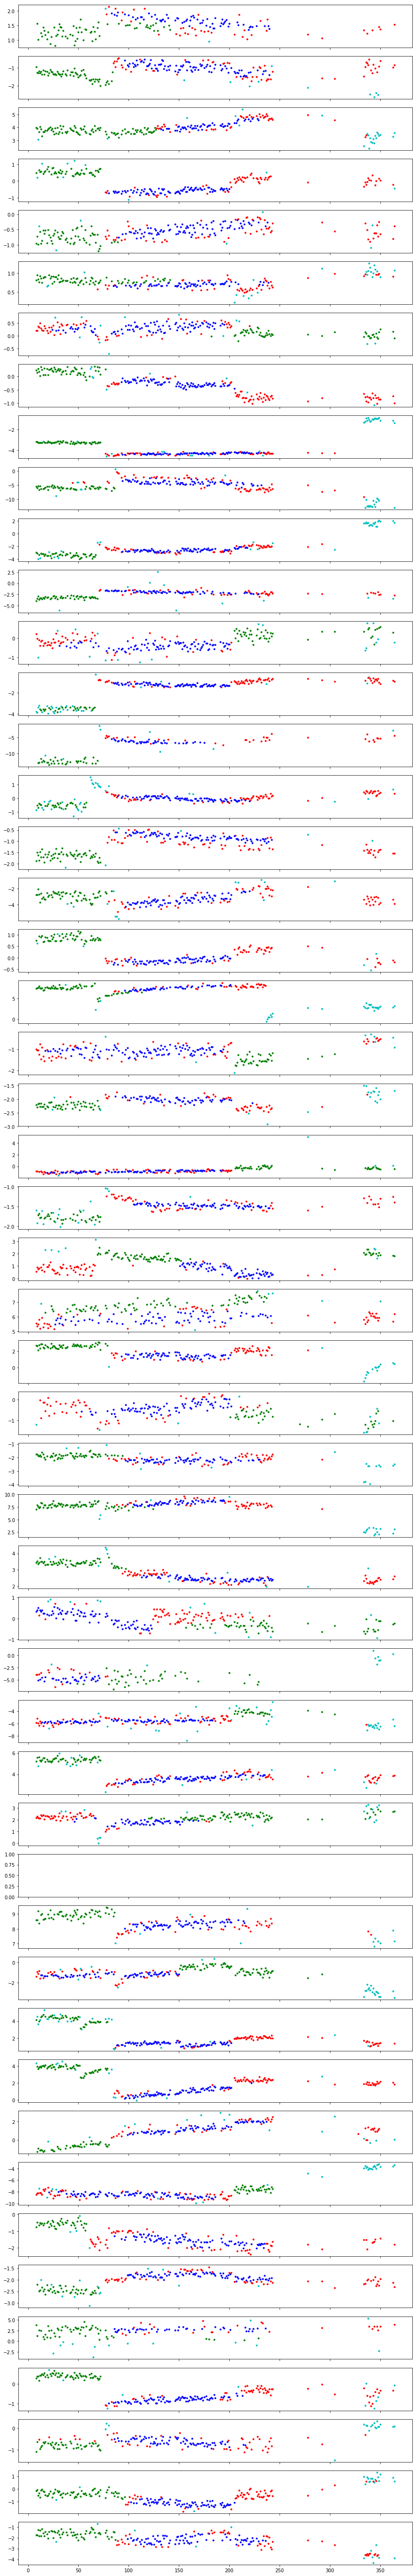

In [99]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['D']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)
#     out1, out2, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

36


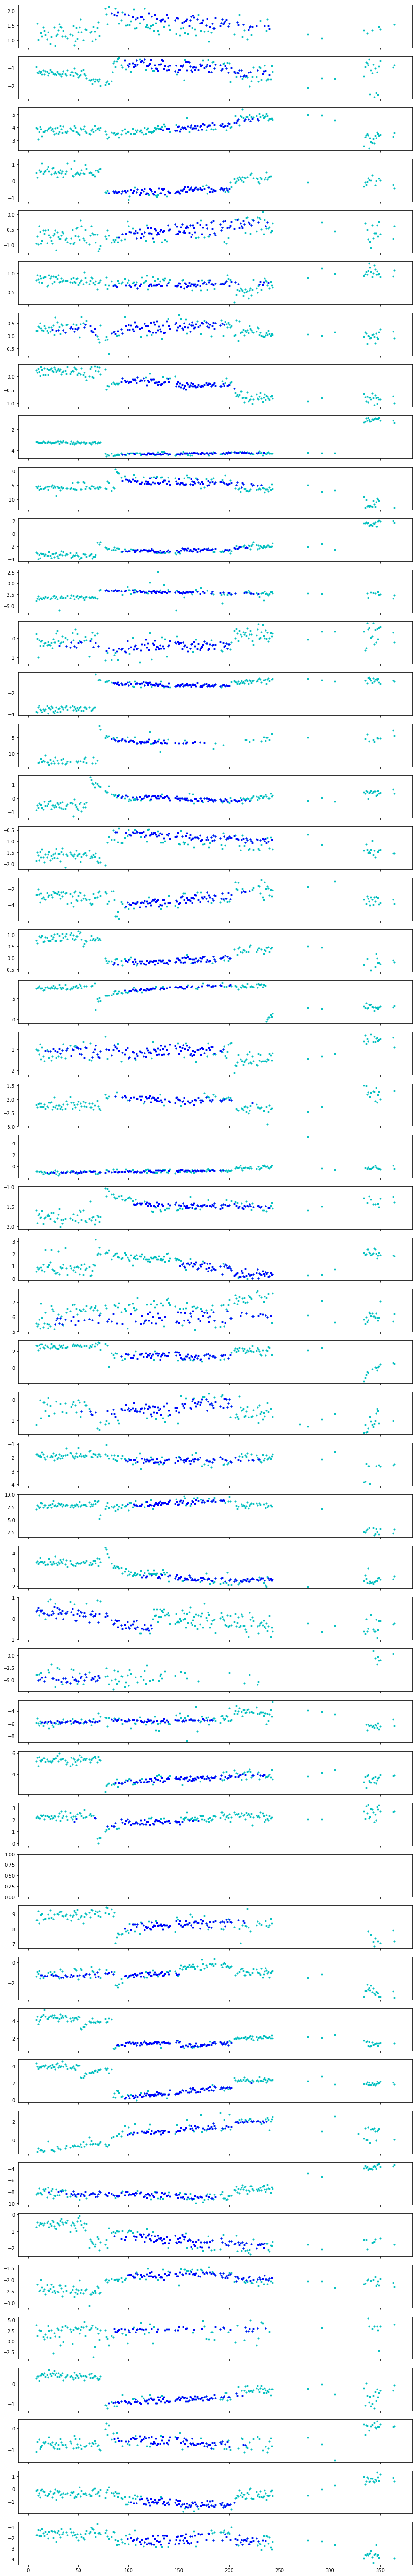

In [113]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['D']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    normal = remove_outliers(data)

    datao = data.copy()
    datal = data.loc[normal]

    axes[i].plot(datao['day'], datao['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

5


32


34


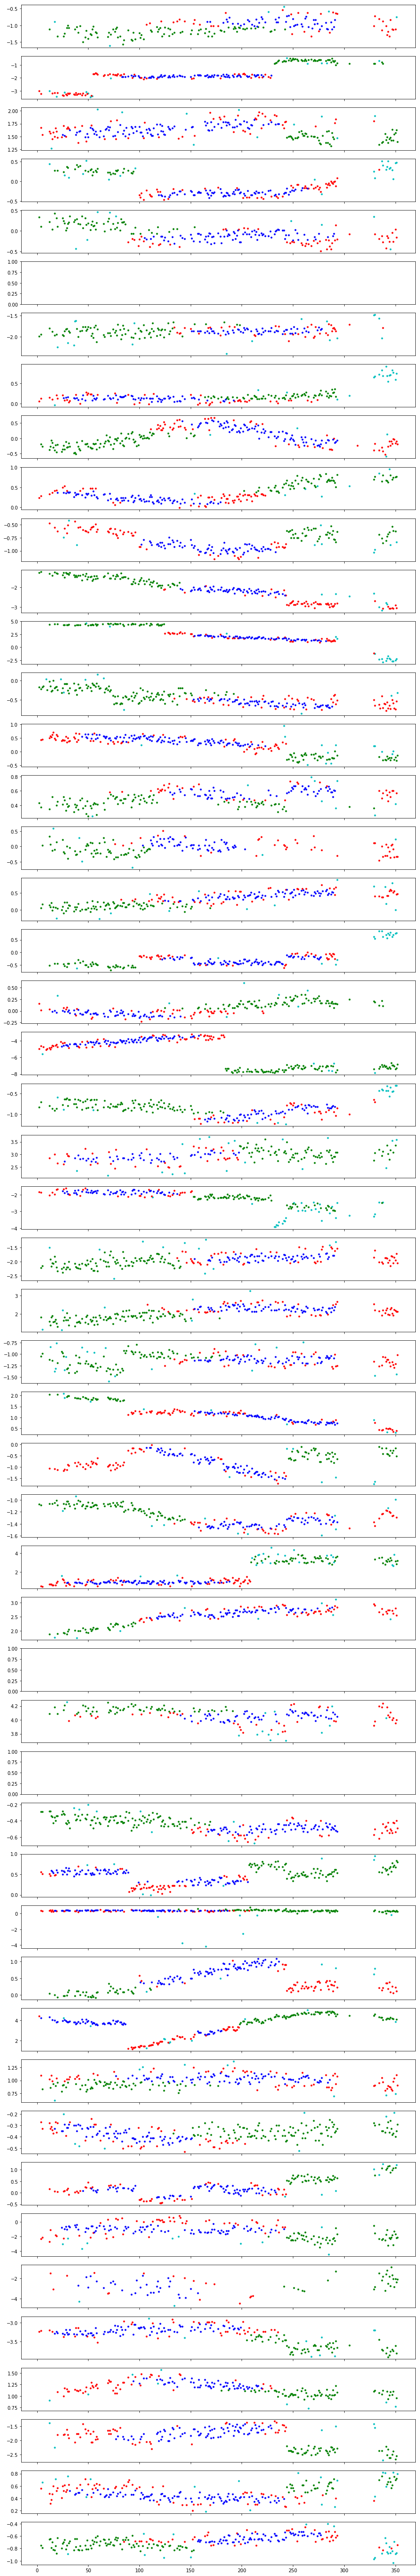

In [100]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['B']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)
#     out1, out2, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

18


44


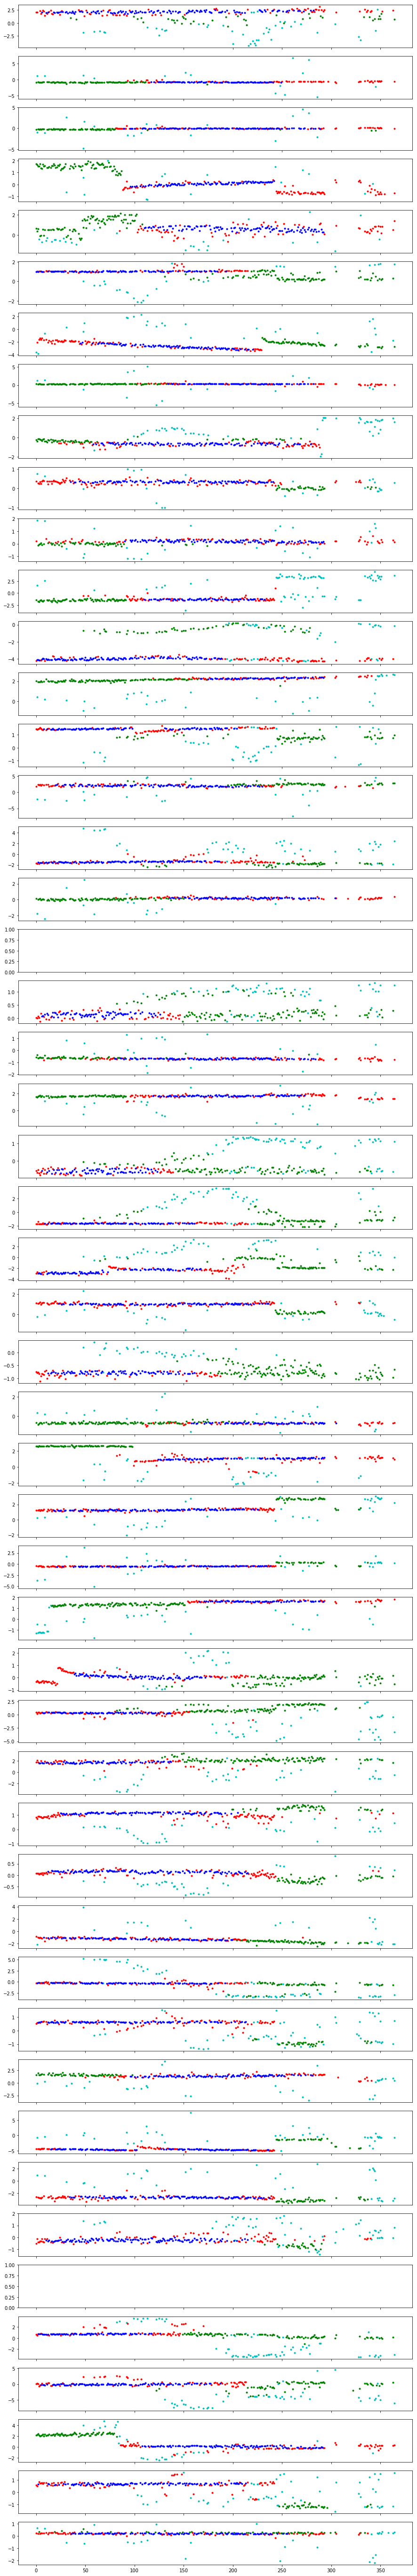

In [97]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['A']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)
#     out1, out2, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

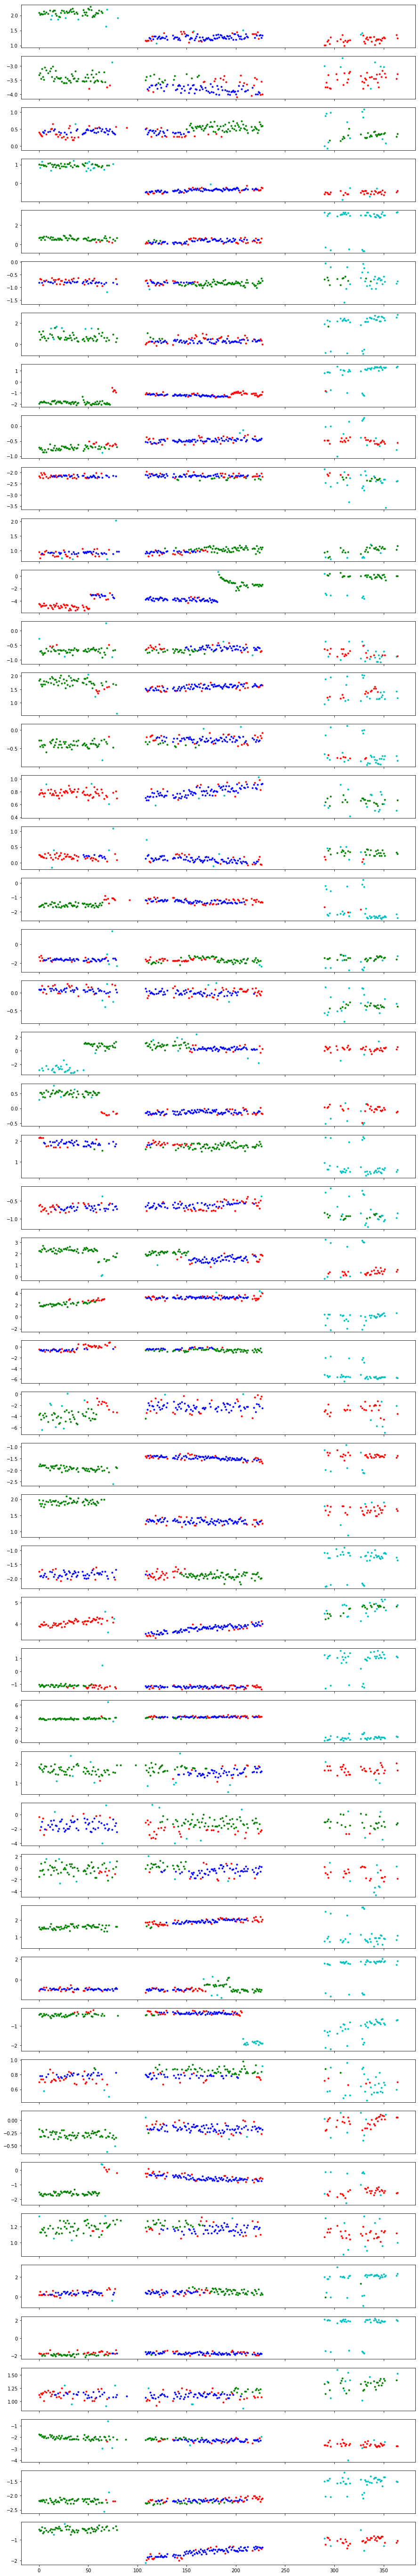

In [98]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)
#     out1, out2, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

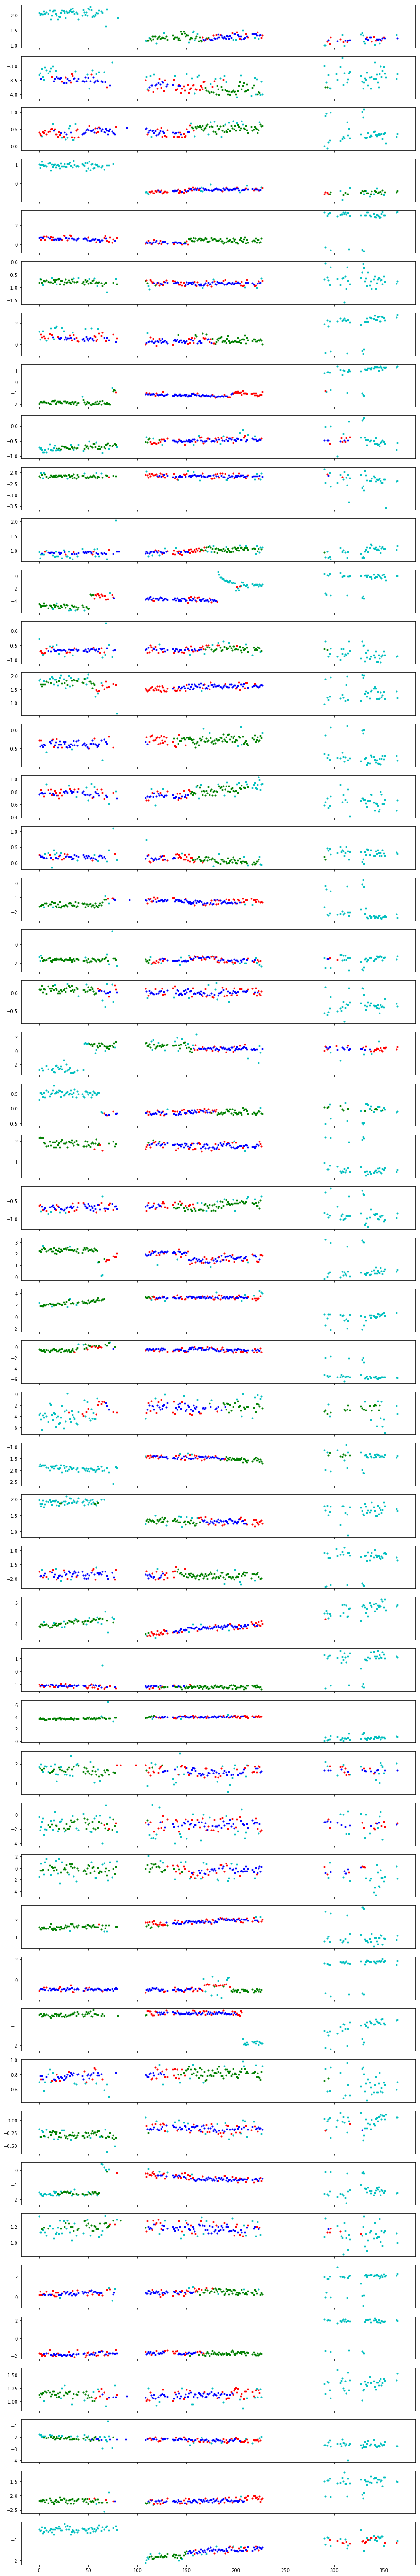

In [16]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [18]:
def get_slope_variance(X, y):
    if len(X) < 10:
        slope = 100
        variance = 100
    else:
        data = np.array([X, y]).T
        pca.fit(data)
        cmp = pca.components_
        cov = pca.get_covariance()

        slope = cmp[0, 1] / cmp[0, 0]
        variance = cov[1, 1] / cov[0, 0]

    return slope, variance

In [19]:
def get_intercept(raw):
    data = raw.copy()
    if sum(data['date'] >= "2018-03-01") == 0:
        print('sum(data["date"] >= "2018-03-01") == 0')
        intercept = np.median(data['高低左'].values[-10:])

    else:
        data = data.loc[data['date'] >= "2018-03-01"]
        data = data.reset_index(drop=True)
        data = data.drop('date', axis=1)
        if len(data) < 4:
            print('sum(data["date"] >= "2018-03-01") < 4')
            intercept = np.median(data['高低左'].values)

        else:
            normal_id = kd_outliers1(data)
            data = data.loc[normal_id]
            intercept = np.median(data['高低左'].values)

    return intercept

In [20]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [26]:
%%time
random.seed(0)

summarys = {}
for no in tqdm(['A', 'B', 'C', 'D']):
    track = tracks[no]
    kilos = track['キロ程'].unique()
#    kilos = track['キロ程'].unique()[:10]
#    kilos = track['キロ程'].unique()[-10:]
    summary = pd.DataFrame(columns=['路線', 'キロ程', '傾き', '切片', '分散比', '測定回数', 'データ数'])

    for i, kilo in enumerate(tqdm(kilos)):
        data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
        data = data.dropna()
        data = data.reset_index(drop=True)

        n_raw_data = len(data)
        data['day'] = get_day(data['date'])
        intercept = get_intercept(data)
        data = data.drop('date', axis=1)

        if len(data) < 10:
            print("len(data) < 10")
            n_data = 0
            slope = 100
            variance = 100
        else:
            normal_id = remove_outliers(data)
            data = data.loc[normal_id]
            data = data.reset_index(drop=True)
            n_data = len(data)
            slope, variance = get_slope_variance(data['day'].values, data['高低左'].values)

        summary.loc[i, '路線'] = no
        summary.loc[i, 'キロ程'] = kilo
        summary.loc[i, '傾き'] = slope
        summary.loc[i, '切片'] = intercept
        summary.loc[i, '分散比'] = variance
        summary.loc[i, '測定回数'] = n_raw_data
        summary.loc[i, 'データ数'] = n_data

        summary['路線'] = summary['路線'].astype('category')
        summary[['傾き', '切片', '分散比']] = summary[['傾き', '切片', '分散比']].astype('float64')
        summary[['キロ程', '測定回数', 'データ数']] = summary[['キロ程', '測定回数', 'データ数']].astype('int32')

    summary.to_csv(f'summary15_{no}.csv')



  0%|          | 0/4 [00:00<?, ?it/s]


0it [00:00, ?it/s]


1it [00:00,  6.86it/s]


2it [00:00,  6.09it/s]


3it [00:00,  4.03it/s]


4it [00:00,  4.30it/s]


5it [00:01,  4.96it/s]


6it [00:01,  5.43it/s]


7it [00:01,  5.32it/s]


8it [00:01,  5.24it/s]


9it [00:01,  5.99it/s]


10it [00:01,  5.53it/s]


11it [00:02,  4.04it/s]


12it [00:02,  3.22it/s]


13it [00:03,  2.71it/s]


14it [00:03,  2.85it/s]


15it [00:03,  3.56it/s]


16it [00:04,  3.45it/s]


17it [00:04,  3.11it/s]


18it [00:04,  2.71it/s]


19it [00:05,  2.66it/s]


20it [00:05,  2.75it/s]


21it [00:05,  3.43it/s]


22it [00:06,  3.14it/s]


23it [00:06,  3.07it/s]


24it [00:07,  2.55it/s]


25it [00:07,  2.38it/s]


26it [00:07,  2.76it/s]


27it [00:08,  2.68it/s]


28it [00:08,  2.64it/s]


29it [00:09,  2.35it/s]


30it [00:09,  2.57it/s]


31it [00:09,  2.95it/s]


32it [00:09,  3.61it/s]


33it [00:09,  4.07it/s]


34it [00:10,  4.07it/s]


35it [00:10,  3.63it/s]


36it [00:11,  2.78it/s]


37it [00:1

KeyboardInterrupt: 

In [24]:
summary#.info()

路線    キロ程        傾き      切片       分散比  測定回数  データ数
0  D  25681  0.007854   7.490  0.000258   184    60
1  D  25682  0.005319   6.285  0.000283   201    52
2  D  25683  0.005233   3.330  0.000162   200    43
3  D  25684  0.001904  -1.305  0.000360   184    47
4  D  25685 -0.025063  -6.580  0.001409   182    37
5  D  25686 -0.000594 -10.660  0.000176   182    67
6  D  25687  0.009102  -9.470  0.000160   181    38
7  D  25688  0.007423  -5.370  0.000290   170    43
8  D  25689 -0.000547  -0.105  0.000144   166    47
9  D  25690 -0.002646   3.655  0.000458   153    30

# LightGBM

In [63]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary15_{no}.csv', index_col=0)

In [64]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].loc[summarys[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['分散比'] == 100, '分散比'] = \
    np.median(summarys[no].loc[summarys[no]['分散比'].notnull(), '分散比'])
    summarys[no].loc[summarys[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['切片'].isnull(), '切片'] = \
    np.median(summarys[no].loc[summarys[no]['切片'].notnull(), '切片'])

In [8]:
summarys["B"]

路線    キロ程        傾き     切片       分散比  測定回数  データ数
0      B  10000 -0.006173 -4.840  0.000054   233   118
1      B  10001 -0.003488 -5.200  0.000052   238    67
2      B  10002 -0.000819 -2.895  0.000019   238    69
3      B  10003  0.005976  0.760  0.000044   238    71
4      B  10004  0.012033  3.400  0.000178   237    74
5      B  10005  0.015339  3.350  0.000284   237    77
6      B  10006  0.011388  0.510  0.000152   238    70
7      B  10007  0.002206 -3.210  0.000017   237    80
8      B  10008 -0.007444 -5.760  0.000087   239    68
9      B  10009 -0.014770 -5.940  0.000296   238    69
10     B  10010 -0.018672 -4.040  0.000424   238    67
11     B  10011 -0.009827 -0.980  0.000142   239    55
12     B  10012 -0.002885  1.765  0.000020   239    82
13     B  10013  0.004841  3.350  0.000078   238    72
14     B  10014  0.009656  3.685  0.000167   238    68
15     B  10015  0.010835  3.070  0.000145   238    70
16     B  10016  0.003252  2.020  0.000015   239    80
17     B  10017  0.004115  1.290  0.000035   240    82
18     B  10018  0.001317  1.390  0.000012   237   116
19     B  10019 -0.000250  2.060  0.000005   233   124
20     B  10020 -0.000273  2.715  0.000004   233    58
21     B  10021 -0.001223  2.850  0.000007   232    67
22     B  10022 -0.001302  2.200  0.000009   231    71
23     B  10023 -0.000937  1.100  0.000005   231    75
24     B  10024 -0.000572  0.175  0.000004   237    67
25     B  10025 -0.001363 -0.220  0.000011   237    68
26     B  10026 -0.001184 -0.015  0.000006   237   120
27     B  10027 -0.001117  0.410  0.000006   239   116
28     B  10028 -0.001010  0.785  0.000007   237    61
29     B  10029  0.001131  0.820  0.000013   237    71
...   ..    ...       ...    ...       ...   ...   ...
21501  B  31501  0.005027 -1.930  0.000051   150    44
21502  B  31502  0.014518 -0.030  0.000246   152    43
21503  B  31503  0.013543  2.230  0.000209   151    48
21504  B  31504  0.004256  3.870  0.000038   150    46
21505  B  31505  0.000917  4.370  0.000004   151    54
21506  B  31506 -0.008189  3.250  0.000110   149    43
21507  B  31507 -0.014612  0.885  0.000274   149    45
21508  B  31508 -0.012339 -1.770  0.000198   151    46
21509  B  31509 -0.001104 -3.610  0.000024   150    50
21510  B  31510 -0.000720 -3.925  0.000011   169    68
21511  B  31511 -0.010328 -2.800  0.000187   194    59
21512  B  31512  0.009787 -1.050  0.000131   196    56
21513  B  31513  0.000327  0.275  0.000025   190    59
21514  B  31514 -0.000722  0.570  0.000010   191    52
21515  B  31515 -0.006506  0.115  0.000051   190    62
21516  B  31516 -0.002395 -0.150  0.000015   191    76
21517  B  31517  0.001370  0.665  0.000031   190    53
21518  B  31518  0.009872  2.625  0.000121   189    56
21519  B  31519  0.012919  4.740  0.000185   191    63
21520  B  31520  0.008804  5.515  0.000131   189    62
21521  B  31521  0.003528  3.960  0.000090   189    56
21522  B  31522 -0.003871  0.390  0.000039   190    73
21523  B  31523  0.008325 -3.610  0.000121   189    61
21524  B  31524 -0.011660 -6.045  0.000153   190    64
21525  B  31525 -0.009580 -5.780  0.000118   190    58
21526  B  31526  0.003827 -3.165  0.000045   189    50
21527  B  31527 -0.008640  0.180  0.000164   190    58
21528  B  31528  0.011789  2.460  0.000161   190    59
21529  B  31529  0.007969  2.805  0.000077   187    59
21530  B  31530  0.004842  1.640  0.000039   164    58

[21531 rows x 7 columns]

In [10]:
import pandas_profiling as pdp

In [11]:
pdp.ProfileReport(summarys["B"])

In [16]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [17]:
train = summarys['A']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i+1}'] = train['slope'].shift(i+1)

In [18]:
train

slope      lag1      lag2      lag3      lag4      lag5      lag6  \
0     -0.003334       NaN       NaN       NaN       NaN       NaN       NaN   
1     -0.002948 -0.003334       NaN       NaN       NaN       NaN       NaN   
2     -0.002168 -0.002948 -0.003334       NaN       NaN       NaN       NaN   
3     -0.001274 -0.002168 -0.002948 -0.003334       NaN       NaN       NaN   
4     -0.000431 -0.001274 -0.002168 -0.002948 -0.003334       NaN       NaN   
5      0.002208 -0.000431 -0.001274 -0.002168 -0.002948 -0.003334       NaN   
6      0.003979  0.002208 -0.000431 -0.001274 -0.002168 -0.002948 -0.003334   
7      0.001004  0.003979  0.002208 -0.000431 -0.001274 -0.002168 -0.002948   
8      0.000590  0.001004  0.003979  0.002208 -0.000431 -0.001274 -0.002168   
9     -0.001097  0.000590  0.001004  0.003979  0.002208 -0.000431 -0.001274   
10    -0.005079 -0.001097  0.000590  0.001004  0.003979  0.002208 -0.000431   
11    -0.005261 -0.005079 -0.001097  0.000590  0.001004  0.003979  0.002208   
12    -0.004409 -0.005261 -0.005079 -0.001097  0.000590  0.001004  0.003979   
13    -0.002875 -0.004409 -0.005261 -0.005079 -0.001097  0.000590  0.001004   
14     0.000368 -0.002875 -0.004409 -0.005261 -0.005079 -0.001097  0.000590   
15    -0.000459  0.000368 -0.002875 -0.004409 -0.005261 -0.005079 -0.001097   
16     0.000531 -0.000459  0.000368 -0.002875 -0.004409 -0.005261 -0.005079   
17     0.004103  0.000531 -0.000459  0.000368 -0.002875 -0.004409 -0.005261   
18     0.004406  0.004103  0.000531 -0.000459  0.000368 -0.002875 -0.004409   
19     0.001415  0.004406  0.004103  0.000531 -0.000459  0.000368 -0.002875   
20     0.009411  0.001415  0.004406  0.004103  0.000531 -0.000459  0.000368   
21    -0.000772  0.009411  0.001415  0.004406  0.004103  0.000531 -0.000459   
22    -0.002404 -0.000772  0.009411  0.001415  0.004406  0.004103  0.000531   
23    -0.003147 -0.002404 -0.000772  0.009411  0.001415  0.004406  0.004103   
24    -0.002551 -0.003147 -0.002404 -0.000772  0.009411  0.001415  0.004406   
25    -0.000190 -0.002551 -0.003147 -0.002404 -0.000772  0.009411  0.001415   
26     0.000803 -0.000190 -0.002551 -0.003147 -0.002404 -0.000772  0.009411   
27     0.001174  0.000803 -0.000190 -0.002551 -0.003147 -0.002404 -0.000772   
28     0.001471  0.001174  0.000803 -0.000190 -0.002551 -0.003147 -0.002404   
29     0.003723  0.001471  0.001174  0.000803 -0.000190 -0.002551 -0.003147   
...         ...       ...       ...       ...       ...       ...       ...   
27876 -0.001103 -0.010482 -0.014429 -0.017359 -0.013940 -0.010527 -0.009163   
27877  0.007524 -0.001103 -0.010482 -0.014429 -0.017359 -0.013940 -0.010527   
27878  0.012214  0.007524 -0.001103 -0.010482 -0.014429 -0.017359 -0.013940   
27879  0.013873  0.012214  0.007524 -0.001103 -0.010482 -0.014429 -0.017359   
27880  0.011419  0.013873  0.012214  0.007524 -0.001103 -0.010482 -0.014429   
27881  0.007631  0.011419  0.013873  0.012214  0.007524 -0.001103 -0.010482   
27882  0.003702  0.007631  0.011419  0.013873  0.012214  0.007524 -0.001103   
27883  0.001867  0.003702  0.007631  0.011419  0.013873  0.012214  0.007524   
27884 -0.000376  0.001867  0.003702  0.007631  0.011419  0.013873  0.012214   
27885 -0.001234 -0.000376  0.001867  0.003702  0.007631  0.011419  0.013873   
27886  0.000671 -0.001234 -0.000376  0.001867  0.003702  0.007631  0.011419   
27887  0.001013  0.000671 -0.001234 -0.000376  0.001867  0.003702  0.007631   
27888  0.000193  0.001013  0.000671 -0.001234 -0.000376  0.001867  0.003702   
27889  0.000252  0.000193  0.001013  0.000671 -0.001234 -0.000376  0.001867   
27890 -0.000943  0.000252  0.000193  0.001013  0.000671 -0.001234 -0.000376   
27891 -0.001884 -0.000943  0.000252  0.000193  0.001013  0.000671 -0.001234   
27892 -0.001450 -0.001884 -0.000943  0.000252  0.000193  0.001013  0.000671   
27893 -0.001578 -0.001450 -0.001884 -0.000943  0.000252  0.000193  0.001013   
27894 -0.001946 -0.001578 -0.001450 -0.001884 -0.000943  0.0

In [19]:
%matplotlib inline

In [20]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 2000x800 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.07696327511182662

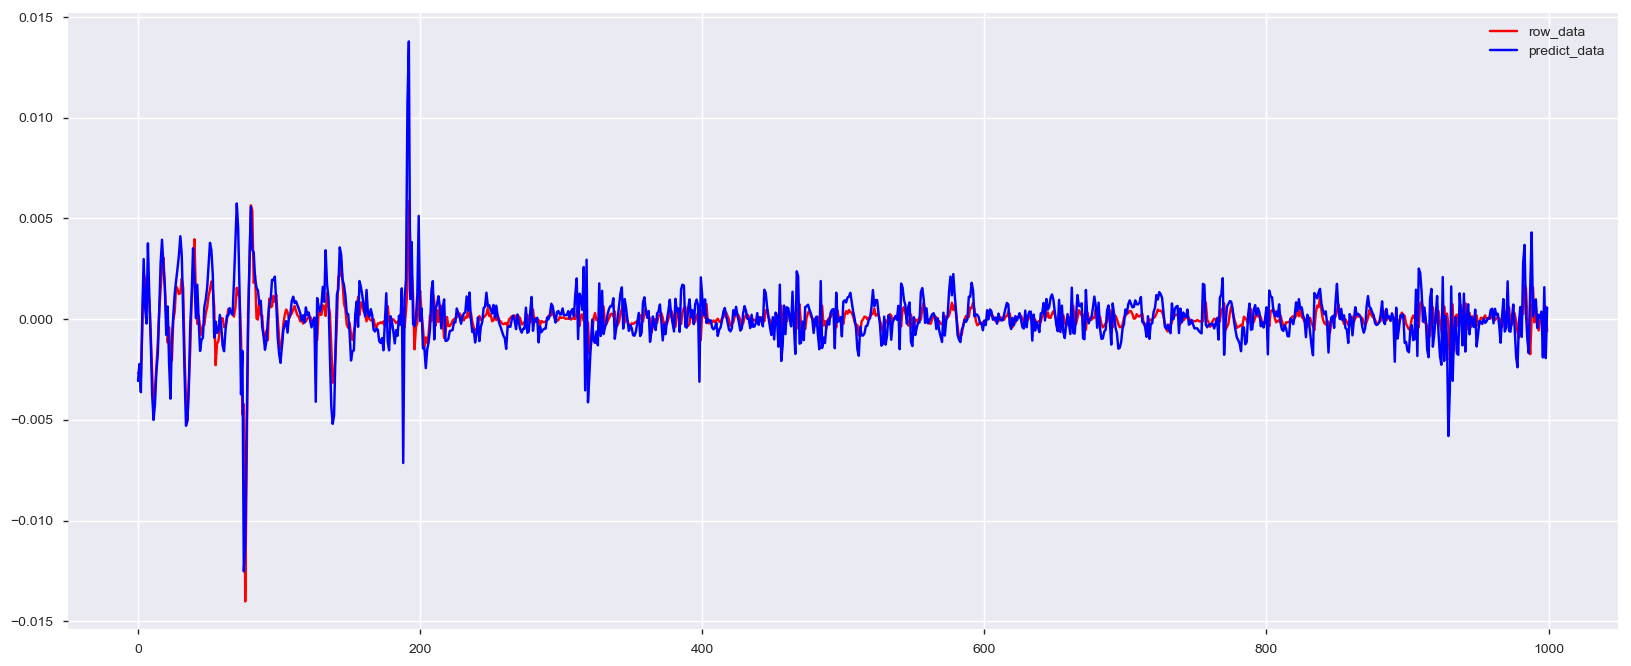

In [56]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[:1000])), train_pred[:1000], color="r", label="row_data")
plt.plot(range(len(y_train[:1000])), y_train[:1000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

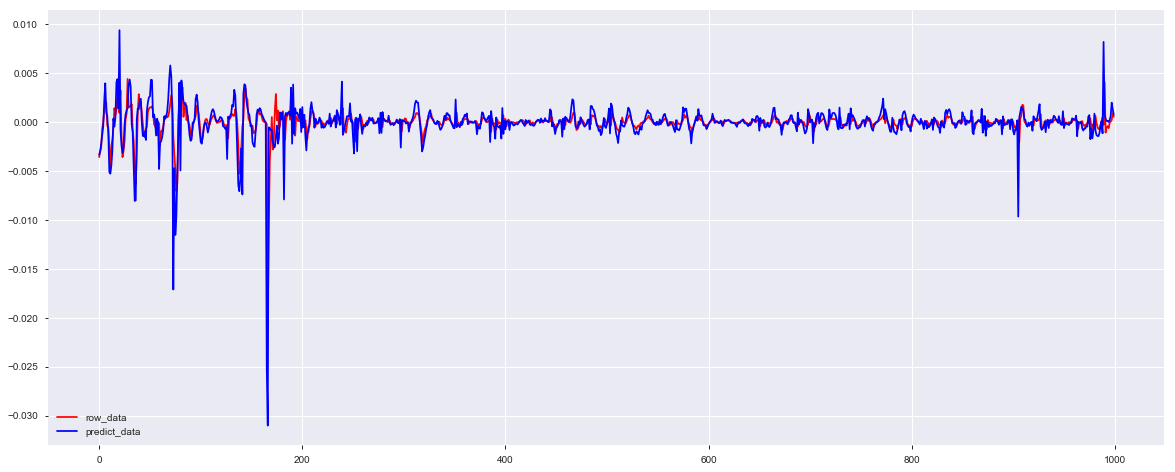

0.3787720841148942

In [21]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[:1000])), train_pred[:1000], color="r", label="row_data")
plt.plot(range(len(y_train[:1000])), y_train[:1000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

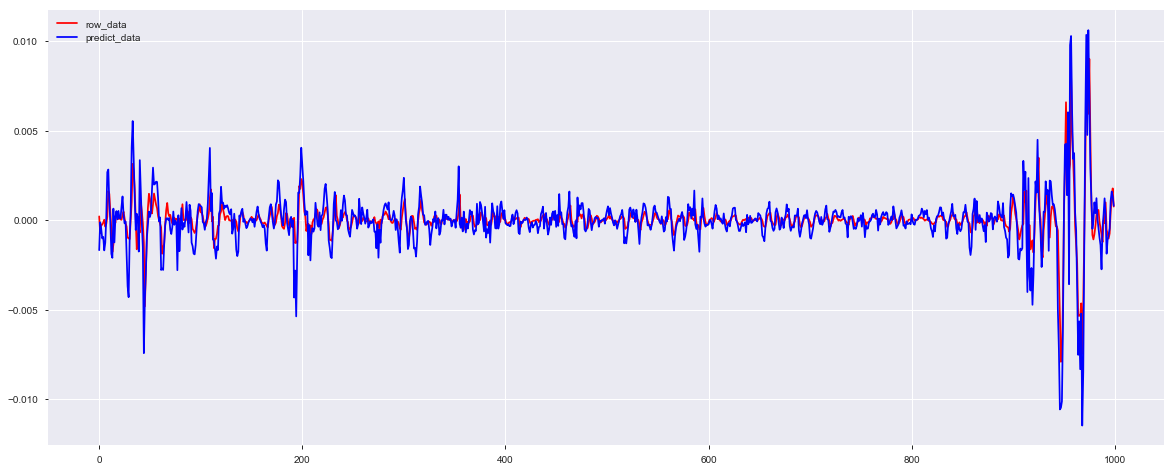

0.07696327511182662

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[-1000:])), train_pred[-1000:], color="r", label="row_data")
plt.plot(range(len(y_train[-1000:])), y_train[-1000:], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

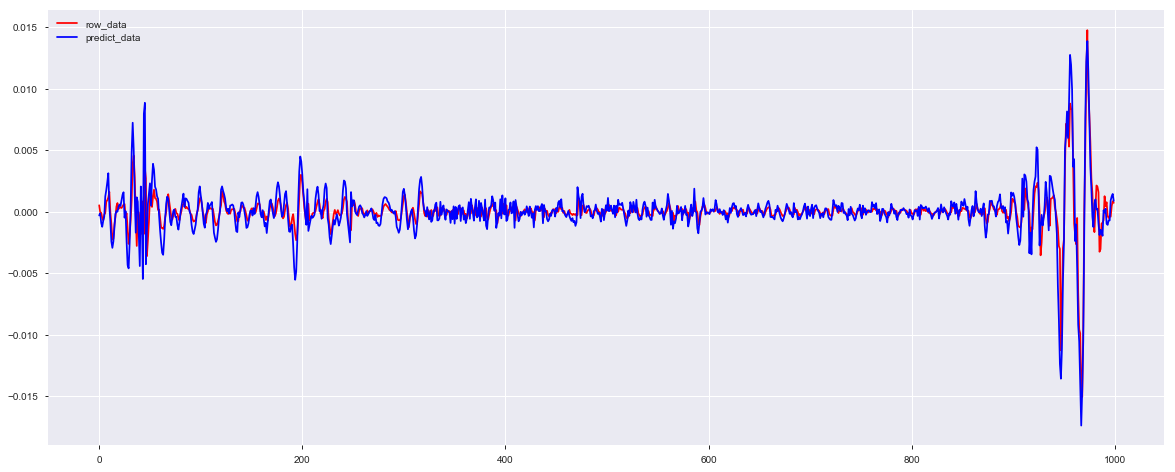

0.3787720841148942

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[-1000:])), train_pred[-1000:], color="r", label="row_data")
plt.plot(range(len(y_train[-1000:])), y_train[-1000:], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

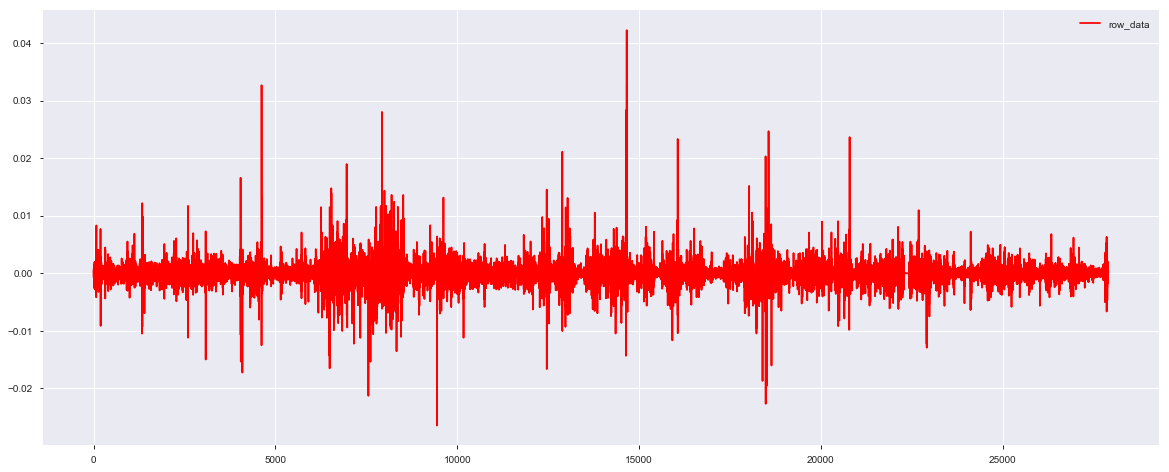

In [60]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred-y_train, color="r", label="row_data")
plt.legend()
plt.show()

<Figure size 1440x576 with 0 Axes>

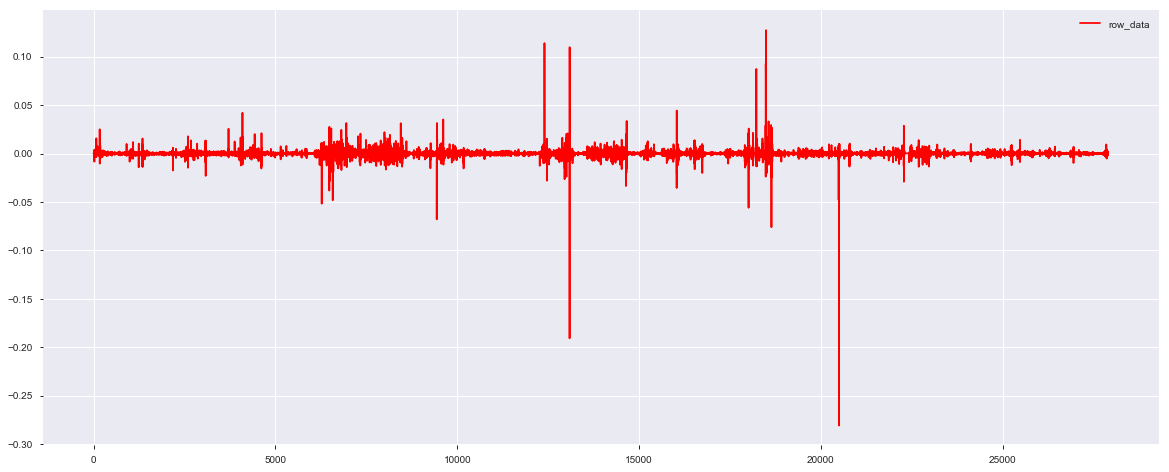

In [23]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred-y_train, color="r", label="row_data")
plt.legend()
plt.show()

In [24]:
summarys['D']

路線    キロ程        傾き      切片       分散比  測定回数  データ数
0      D  10000 -0.000067  -0.700  0.000009   211    81
1      D  10001  0.003142  -0.450  0.000017   211    73
2      D  10002 -0.002506   0.345  0.000011   212    65
3      D  10003 -0.000782   1.275  0.000007   213    82
4      D  10004 -0.000831   1.525  0.000019   212    99
5      D  10005 -0.001182   0.730  0.000032   213    99
6      D  10006 -0.002717  -0.400  0.000023   213    92
7      D  10007 -0.000113  -1.035  0.000017   213    90
8      D  10008  0.001410  -0.315  0.000010   214    61
9      D  10009 -0.001101   1.695  0.000031   213    83
10     D  10010  0.006608   3.480  0.000086   213    83
11     D  10011 -0.003984   3.525  0.000125   213    90
12     D  10012 -0.012361   0.990  0.000481   214    87
13     D  10013 -0.006652  -3.230  0.000481   213    99
14     D  10014 -0.006278  -6.940  0.000588   213    99
15     D  10015 -0.006177  -7.915  0.000088   214    76
16     D  10016 -0.004575  -5.605  0.000039   214    60
17     D  10017 -0.005724  -1.400  0.000064   213   104
18     D  10018 -0.001320   2.390  0.000023   213    90
19     D  10019  0.000259   3.780  0.000015   213    92
20     D  10020  0.004765   2.760  0.000091   215    94
21     D  10021  0.004041   0.170  0.000044   214   103
22     D  10022  0.003334  -2.540  0.000032   214    87
23     D  10023  0.000828  -3.595  0.000006   215    93
24     D  10024  0.000841  -3.500  0.000015   215    90
25     D  10025 -0.002282  -2.450  0.000010   213    96
26     D  10026  0.000752  -1.030  0.000014   213    93
27     D  10027  0.000444   0.040  0.000005   215    90
28     D  10028 -0.000329   0.370  0.000007   215    96
29     D  10029 -0.001720  -0.060  0.000012   216    95
...   ..    ...       ...     ...       ...   ...   ...
15661  D  25661  0.008114  -0.310  0.000143   124    40
15662  D  25662  0.012635  -1.210  0.000352   125    37
15663  D  25663 -0.007250  -1.725  0.000526   125    48
15664  D  25664 -0.001878  -1.630  0.000720   124    44
15665  D  25665 -0.004007  -0.750  0.000129   125    47
15666  D  25666  0.006499   0.850  0.000224   124    32
15667  D  25667  0.005141   3.250  0.000106   123    36
15668  D  25668  0.007458   3.940  0.000322   122    40
15669  D  25669  0.011299   4.420  0.000511   122    46
15670  D  25670 -0.002333   3.960  0.000028   122    46
15671  D  25671 -0.000447   2.430  0.000075   121    53
15672  D  25672 -0.007454  -0.825  0.000422   123    42
15673  D  25673  0.025318  -4.785  0.001177   128    43
15674  D  25674 -0.011468  -7.185  0.000422   143    61
15675  D  25675 -0.005987  -7.095  0.000204   148    62
15676  D  25676 -0.017635  -5.380  0.001094   148    44
15677  D  25677 -0.000502  -2.570  0.000140   157    56
15678  D  25678  0.010171   0.805  0.000348   179    71
15679  D  25679  0.012053   3.950  0.000608   181    73
15680  D  25680  0.013149   6.990  0.000589   182    69
15681  D  25681  0.009686   7.490  0.000447   184    64
15682  D  25682  0.003584   6.285  0.000263   201    77
15683  D  25683 -0.001450   3.330  0.000098   200    87
15684  D  25684 -0.008132  -1.305  0.000322   184    80
15685  D  25685 -0.005648  -6.580  0.000500   182    76
15686  D  25686 -0.004116 -11.000  0.000303   182    73
15687  D  25687 -0.009247  -9.580  0.000545   181    51
15688  D  25688  0.003789  -5.370  0.000809   170    42
15689  D  25689  0.003860  -0.105  0.000221   166    77
15690  D  25690 -0.003719   3.655  0.000206   153    57

[15691 rows x 7 columns]

In [25]:
train = summarys['D']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i+1}'] = train['slope'].shift(i+1)

In [26]:
train

slope      lag1      lag2      lag3      lag4      lag5      lag6  \
0     -0.000067       NaN       NaN       NaN       NaN       NaN       NaN   
1      0.003142 -0.000067       NaN       NaN       NaN       NaN       NaN   
2     -0.002506  0.003142 -0.000067       NaN       NaN       NaN       NaN   
3     -0.000782 -0.002506  0.003142 -0.000067       NaN       NaN       NaN   
4     -0.000831 -0.000782 -0.002506  0.003142 -0.000067       NaN       NaN   
5     -0.001182 -0.000831 -0.000782 -0.002506  0.003142 -0.000067       NaN   
6     -0.002717 -0.001182 -0.000831 -0.000782 -0.002506  0.003142 -0.000067   
7     -0.000113 -0.002717 -0.001182 -0.000831 -0.000782 -0.002506  0.003142   
8      0.001410 -0.000113 -0.002717 -0.001182 -0.000831 -0.000782 -0.002506   
9     -0.001101  0.001410 -0.000113 -0.002717 -0.001182 -0.000831 -0.000782   
10     0.006608 -0.001101  0.001410 -0.000113 -0.002717 -0.001182 -0.000831   
11    -0.003984  0.006608 -0.001101  0.001410 -0.000113 -0.002717 -0.001182   
12    -0.012361 -0.003984  0.006608 -0.001101  0.001410 -0.000113 -0.002717   
13    -0.006652 -0.012361 -0.003984  0.006608 -0.001101  0.001410 -0.000113   
14    -0.006278 -0.006652 -0.012361 -0.003984  0.006608 -0.001101  0.001410   
15    -0.006177 -0.006278 -0.006652 -0.012361 -0.003984  0.006608 -0.001101   
16    -0.004575 -0.006177 -0.006278 -0.006652 -0.012361 -0.003984  0.006608   
17    -0.005724 -0.004575 -0.006177 -0.006278 -0.006652 -0.012361 -0.003984   
18    -0.001320 -0.005724 -0.004575 -0.006177 -0.006278 -0.006652 -0.012361   
19     0.000259 -0.001320 -0.005724 -0.004575 -0.006177 -0.006278 -0.006652   
20     0.004765  0.000259 -0.001320 -0.005724 -0.004575 -0.006177 -0.006278   
21     0.004041  0.004765  0.000259 -0.001320 -0.005724 -0.004575 -0.006177   
22     0.003334  0.004041  0.004765  0.000259 -0.001320 -0.005724 -0.004575   
23     0.000828  0.003334  0.004041  0.004765  0.000259 -0.001320 -0.005724   
24     0.000841  0.000828  0.003334  0.004041  0.004765  0.000259 -0.001320   
25    -0.002282  0.000841  0.000828  0.003334  0.004041  0.004765  0.000259   
26     0.000752 -0.002282  0.000841  0.000828  0.003334  0.004041  0.004765   
27     0.000444  0.000752 -0.002282  0.000841  0.000828  0.003334  0.004041   
28    -0.000329  0.000444  0.000752 -0.002282  0.000841  0.000828  0.003334   
29    -0.001720 -0.000329  0.000444  0.000752 -0.002282  0.000841  0.000828   
...         ...       ...       ...       ...       ...       ...       ...   
15661  0.008114  0.002191 -0.003292  0.000173  0.002078  0.001829  0.002599   
15662  0.012635  0.008114  0.002191 -0.003292  0.000173  0.002078  0.001829   
15663 -0.007250  0.012635  0.008114  0.002191 -0.003292  0.000173  0.002078   
15664 -0.001878 -0.007250  0.012635  0.008114  0.002191 -0.003292  0.000173   
15665 -0.004007 -0.001878 -0.007250  0.012635  0.008114  0.002191 -0.003292   
15666  0.006499 -0.004007 -0.001878 -0.007250  0.012635  0.008114  0.002191   
15667  0.005141  0.006499 -0.004007 -0.001878 -0.007250  0.012635  0.008114   
15668  0.007458  0.005141  0.006499 -0.004007 -0.001878 -0.007250  0.012635   
15669  0.011299  0.007458  0.005141  0.006499 -0.004007 -0.001878 -0.007250   
15670 -0.002333  0.011299  0.007458  0.005141  0.006499 -0.004007 -0.001878   
15671 -0.000447 -0.002333  0.011299  0.007458  0.005141  0.006499 -0.004007   
15672 -0.007454 -0.000447 -0.002333  0.011299  0.007458  0.005141  0.006499   
15673  0.025318 -0.007454 -0.000447 -0.002333  0.011299  0.007458  0.005141   
15674 -0.011468  0.025318 -0.007454 -0.000447 -0.002333  0.011299  0.007458   
15675 -0.005987 -0.011468  0.025318 -0.007454 -0.000447 -0.002333  0.011299   
15676 -0.017635 -0.005987 -0.011468  0.025318 -0.007454 -0.000447 -0.002333   
15677 -0.000502 -0.017635 -0.005987 -0.011468  0.025318 -0.007454 -0.000447   
15678  0.010171 -0.000502 -0.017635 -0.005987 -0.011468  0.025318 -0.007454   
15679  0.012053  0.010171 -0.000502 -0.017635 -0.005987 -0.0

In [27]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

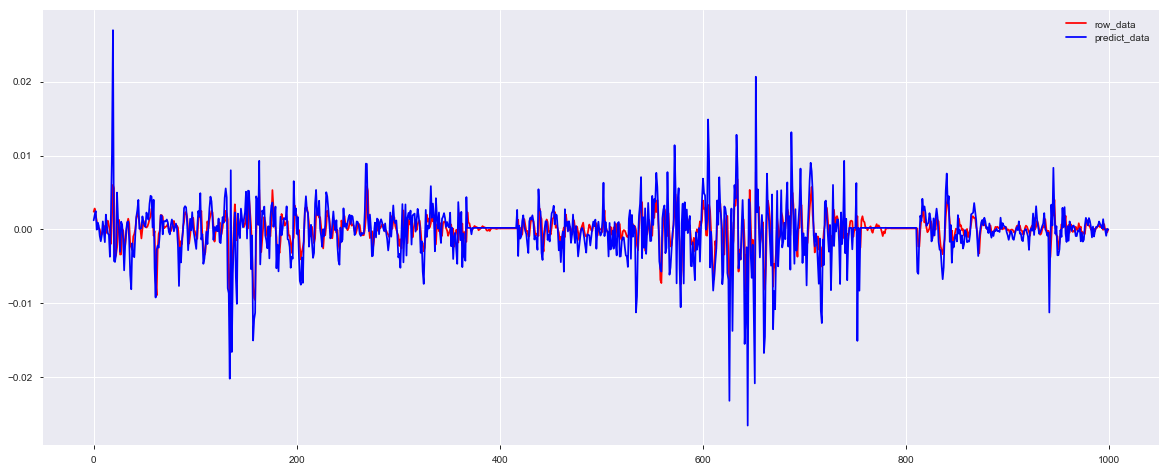

0.16541781384242685

In [65]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[3000:4000])), train_pred[3000:4000], color="r", label="row_data")
plt.plot(range(len(y_train[3000:4000])), y_train[3000:4000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

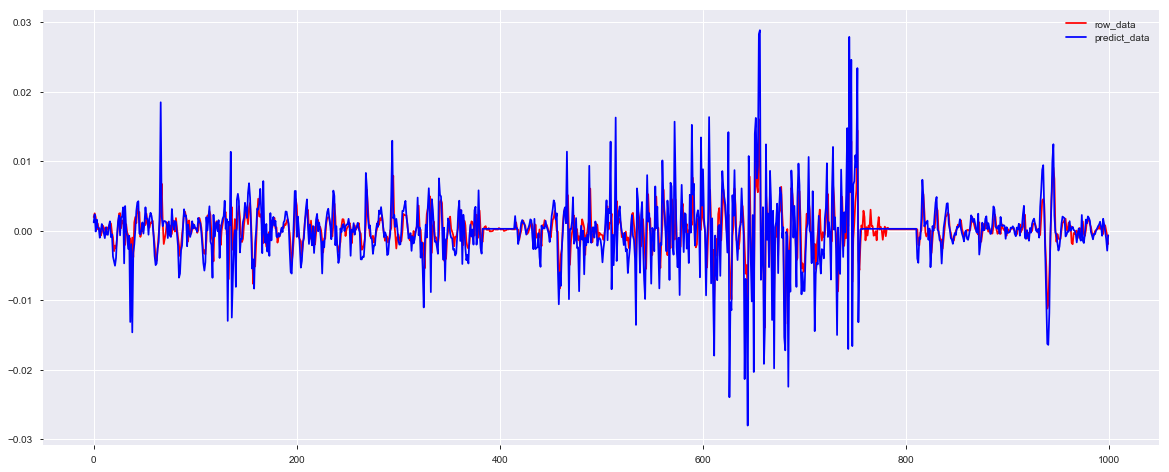

0.20132718433502453

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[3000:4000])), train_pred[3000:4000], color="r", label="row_data")
plt.plot(range(len(y_train[3000:4000])), y_train[3000:4000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

In [62]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys[no]['傾き'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

KeyboardInterrupt: 

In [30]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].to_csv(f'summary15_{no}_lgbm.csv')

In [90]:
summarys["A"]

路線    キロ程        傾き     切片       分散比  測定回数  データ数
0      A  10000 -0.003334  0.570  0.000022   261   111
1      A  10001 -0.002948  2.880  0.000018   260    82
2      A  10002 -0.002168  5.100  0.000013   259    96
3      A  10003 -0.001274  5.880  0.000013   259    92
4      A  10004 -0.000431  5.000  0.000019   261    92
5      A  10005  0.002208  1.690  0.000024   261   110
6      A  10006  0.003979 -3.100  0.000051   257   106
7      A  10007  0.001004 -7.255  0.000035   255    74
8      A  10008  0.000590 -8.850  0.000017   251    73
9      A  10009 -0.001097 -7.430  0.000015   251    70
10     A  10010 -0.005079 -3.340  0.000038   248    62
11     A  10011 -0.005261  1.130  0.000046   248    87
12     A  10012 -0.004409  4.600  0.000038   241    80
13     A  10013 -0.002875  5.460  0.000048   244    84
14     A  10014  0.000368  3.750  0.000086   257    70
15     A  10015 -0.000459  1.015  0.000029   258    79
16     A  10016  0.000531 -2.710  0.000006   256   100
17     A  10017  0.004103 -4.850  0.000022   256   119
18     A  10018  0.004406 -5.030  0.000026   256    94
19     A  10019  0.001415 -3.690  0.000088   254    59
20     A  10020  0.009411 -1.910  0.000126   254    70
21     A  10021 -0.000772 -0.460  0.000003   251    95
22     A  10022 -0.002404  0.025  0.000011   249    91
23     A  10023 -0.003147  0.230  0.000016   252    93
24     A  10024 -0.002551  0.920  0.000012   253   119
25     A  10025 -0.000190  2.335  0.000004   260   105
26     A  10026  0.000803  3.835  0.000004   260   104
27     A  10027  0.001174  4.055  0.000005   259   107
28     A  10028  0.001471  1.920  0.000008   260   123
29     A  10029  0.003723 -1.885  0.000018   261    67
...   ..    ...       ...    ...       ...   ...   ...
27876  A  37876 -0.001103 -3.665  0.000033   198    55
27877  A  37877  0.007524 -1.390  0.000084   198    52
27878  A  37878  0.012214  1.450  0.000192   202    59
27879  A  37879  0.013873  3.205  0.000210   246    78
27880  A  37880  0.011419  3.420  0.000148   257    86
27881  A  37881  0.007631  2.460  0.000093   258    84
27882  A  37882  0.003702  0.310  0.000040   260    78
27883  A  37883  0.001867 -1.820  0.000016   256    75
27884  A  37884 -0.000376 -2.360  0.000007   257    78
27885  A  37885 -0.001234 -1.990  0.000010   255    88
27886  A  37886  0.000671 -0.870  0.000015   257    66
27887  A  37887  0.001013  0.770  0.000006   258   104
27888  A  37888  0.000193  1.255  0.000005   257    92
27889  A  37889  0.000252  1.360  0.000002   260    91
27890  A  37890 -0.000943  1.065  0.000004   259   126
27891  A  37891 -0.001884  0.320  0.000011   254    66
27892  A  37892 -0.001450 -0.230  0.000007   254    89
27893  A  37893 -0.001578 -0.545  0.000008   253    76
27894  A  37894 -0.001946 -0.580  0.000010   253    86
27895  A  37895  0.000132 -0.410  0.000004   251    86
27896  A  37896 -0.000060 -0.280  0.000002   250   109
27897  A  37897  0.000252 -0.330  0.000002   251    83
27898  A  37898 -0.000955 -0.355  0.000006   252    93
27899  A  37899 -0.001060 -0.145  0.000012   254    62
27900  A  37900 -0.000690  0.880  0.000008   255    69
27901  A  37901 -0.000694  1.915  0.000003   251   101
27902  A  37902  0.000928  2.290  0.000003   251    75
27903  A  37903  0.001262  2.340  0.000008   251    80
27904  A  37904  0.001454  1.480  0.000013   251    71
27905  A  37905  0.000886  0.300  0.000013   254    89

[27906 rows x 7 columns]

In [91]:
%%time
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
#     submit = pd.concat([submit, summary[['路線', 'キロ程', '傾き', '切片']]], axis=0)
    submit = pd.concat([submit, summary], axis=0)
submit = submit.reset_index(drop=True)

CPU times: user 47.6 ms, sys: 21.4 ms, total: 69.1 ms
Wall time: 60 ms


In [74]:
pdp.ProfileReport(submit)

In [92]:
low = submit.sort_values('傾き').head()
high = submit.sort_values('傾き', ascending=False).head()
out_df = pd.concat([low, high], axis=0)
# out = out_df[['路線', 'キロ程']].values
out_df

路線    キロ程        傾き     切片       分散比  測定回数  データ数
18494   A  28494 -0.271769  0.370  0.144212    33    11
102650  C  63213 -0.222479 -2.535  0.053825    28    10
18487   A  28487 -0.216587 -2.810  0.051126    31    10
102651  C  63214 -0.209360 -2.690  0.045030    28    10
56434   C  16997 -0.208009  7.045  0.045574   101    35
20502   A  30502  0.448223 -1.235  0.404724    31    10
13090   A  23090  0.242641 -3.680  0.071719    38    13
90117   C  50680  0.172945 -3.000  0.035206    49    16
18012   A  28012  0.160673  9.035  0.029088    31    12
18013   A  28013  0.156322  8.175  0.027431    31    10

Text(0.5, 1.0, 'kilo: 28494,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 63213,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28487,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 63214,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16997,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 30502,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23090,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 50680,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28012,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28013,  kilo_id: 18013')

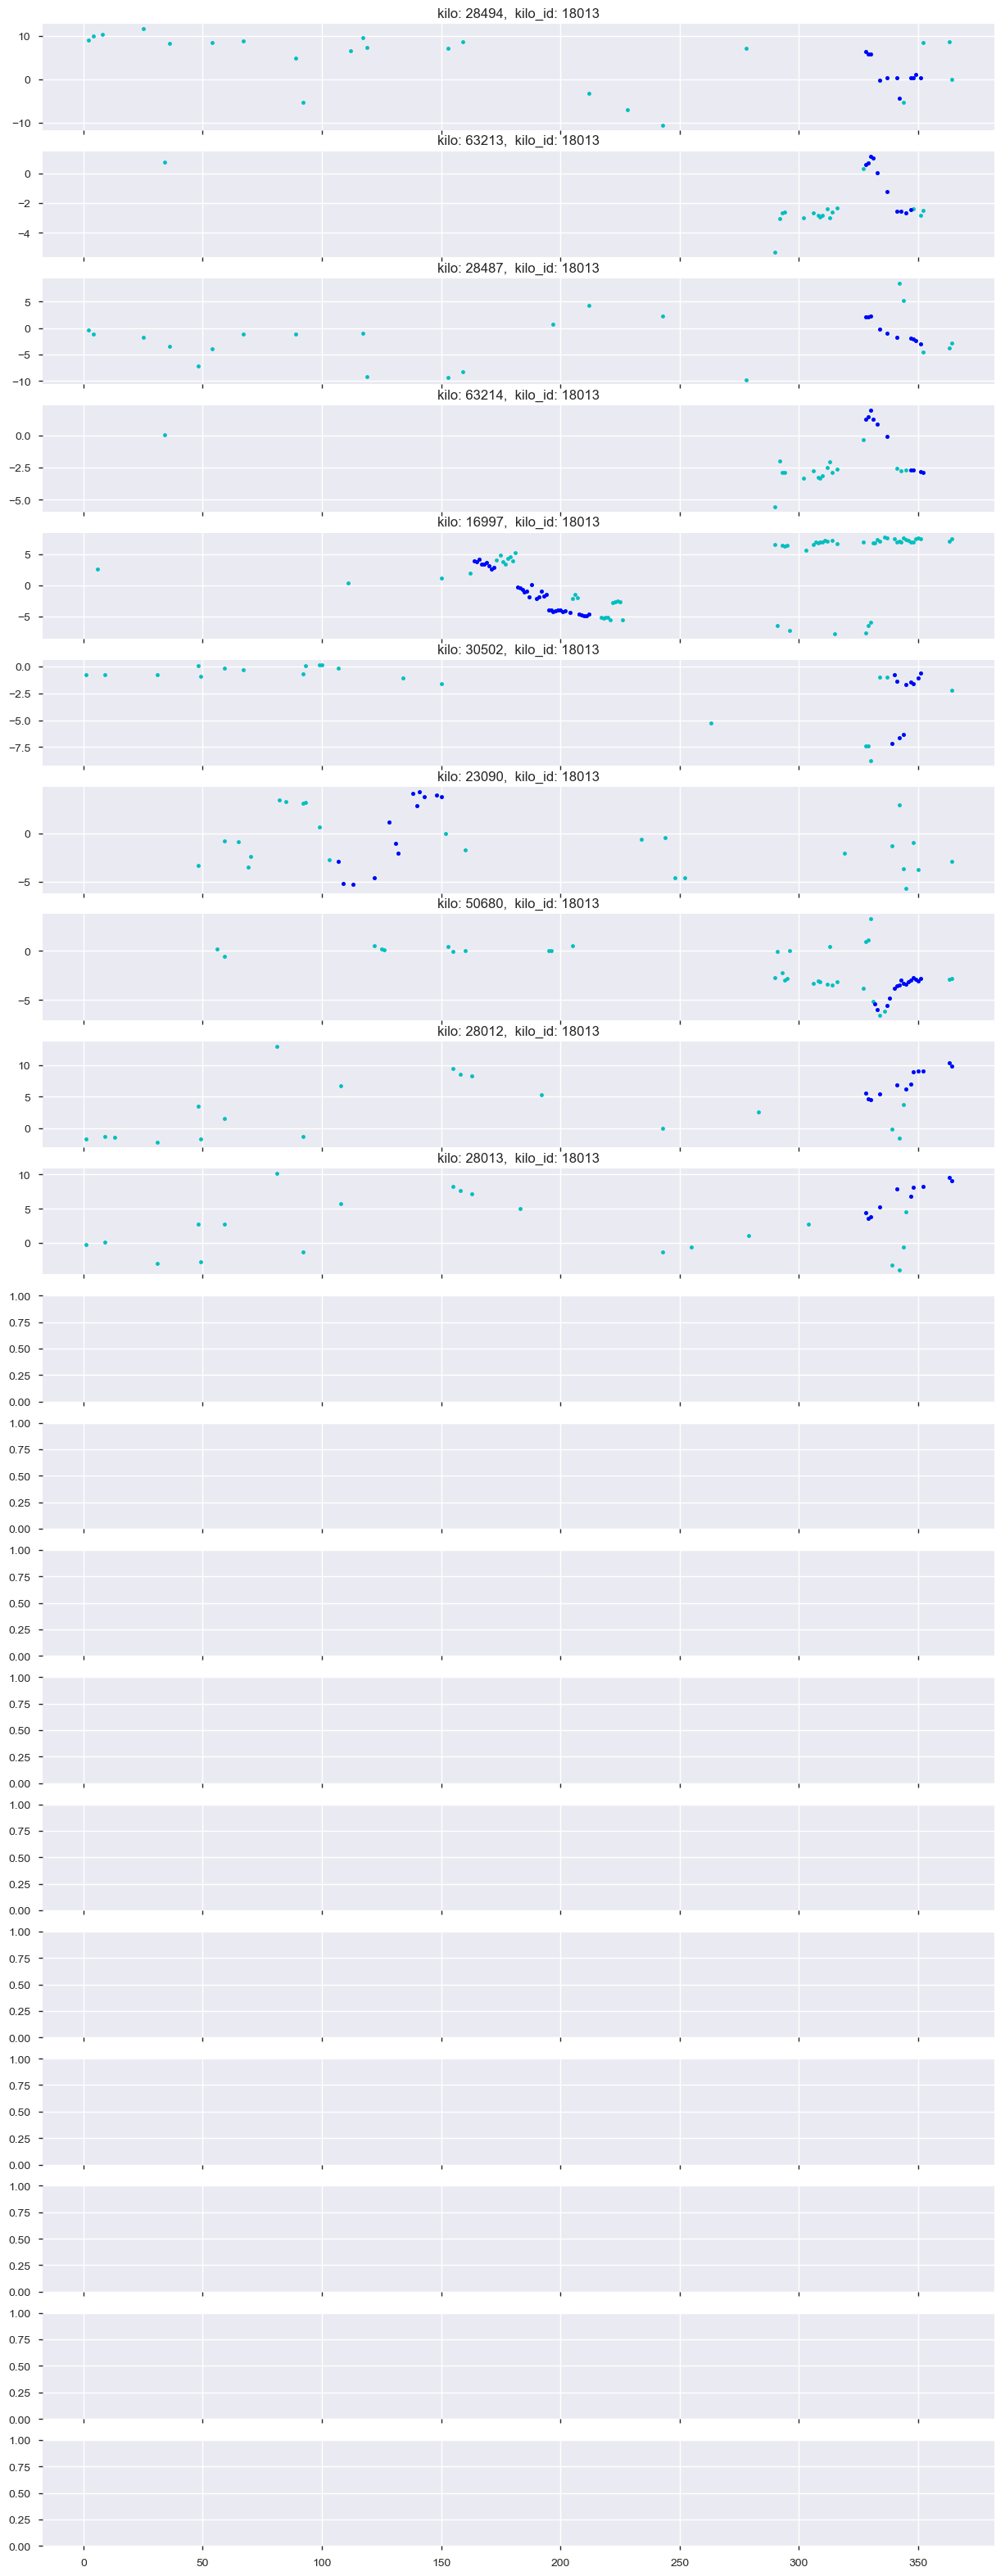

In [88]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

for i, (no, kilo) in enumerate(out):
    track = tracks[no]
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

#     kilo_id = kilo - 10000
#     hoge = [kilo_id + i*len(kilos) for i in range(91)]
#     piyo = submision.loc[hoge, 0]
#     axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [113]:
high_df = submit.sort_values('分散比', ascending=False).head(10)
high = high_df[['路線', 'キロ程']].values
high_df

路線    キロ程        傾き     切片       分散比  測定回数  データ数
20502   A  30502  0.448223 -1.235  0.404724    31    10
18494   A  28494 -0.271769  0.370  0.144212    33    11
4046    A  14046  0.006017 -1.050  0.072747    41    12
13090   A  23090  0.242641 -3.680  0.071719    38    13
18486   A  28486 -0.204844 -1.370  0.060689    32    12
102650  C  63213 -0.222479 -2.535  0.053825    28    10
18487   A  28487 -0.216587 -2.810  0.051126    31    10
18485   A  28485 -0.164168  1.180  0.049865    34    13
56434   C  16997 -0.208009  7.045  0.045574   101    35
102651  C  63214 -0.209360 -2.690  0.045030    28    10

Text(0.5, 1.0, 'kilo: 30502,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28494,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 14046,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23090,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28486,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 63213,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28487,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28485,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16997,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 63214,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 14048,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 50680,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28642,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23088,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28012,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28013,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 22399,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23091,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16633,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11853,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28011,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 32284,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28014,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39212,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33475,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16998,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28017,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28648,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33472,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 30490,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44383,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 64087,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 22400,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 30498,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28226,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39214,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39201,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33469,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39206,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16996,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28010,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 59084,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16617,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 64088,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11854,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 32285,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 30497,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 50679,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39205,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19319,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28023,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44282,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33477,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39215,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 17001,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 64096,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44382,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39213,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44384,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19322,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44969,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 21276,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23263,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24653,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33479,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28650,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19440,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23260,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28492,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33418,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28658,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 51735,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39203,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19241,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39207,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 21151,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23085,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39228,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 62382,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28227,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33529,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19437,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33480,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11663,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 21159,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 59080,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11665,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19438,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23262,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28651,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39204,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 64095,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33474,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19443,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44975,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 59083,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19436,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11658,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39210,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16273,  kilo_id: 18013')

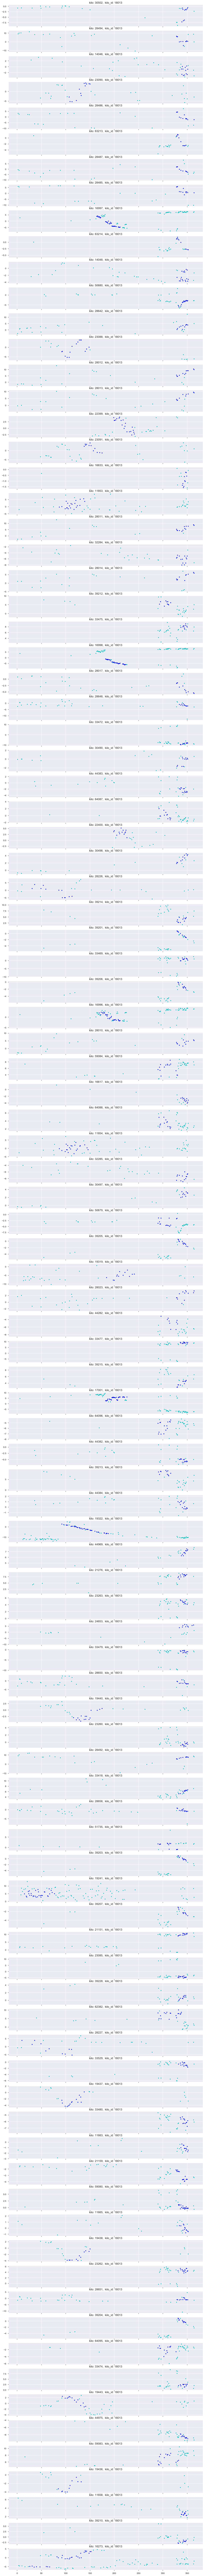

In [104]:
random.seed(10)

# fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)
fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True)

for i, (no, kilo) in enumerate(high):
    track = tracks[no]
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

#     kilo_id = kilo - 10000
#     hoge = [kilo_id + i*len(kilos) for i in range(91)]
#     piyo = submision.loc[hoge, 0]
#     axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [ ]:
19322

In [107]:
high_df = submit.sort_values('分散比', ascending=False).iloc[100:200]
high = high_df[['路線', 'キロ程']].values
high_df

路線    キロ程        傾き      切片       分散比  測定回数  データ数
14661   A  24661 -0.073294   2.530  0.006460    34    11
18653   A  28653  0.064157   0.180  0.006375    44    13
4092    A  14092 -0.077404  -3.670  0.006263    66    20
101827  C  62390  0.070271  -6.800  0.006225    41    16
102655  C  63218 -0.073412  -0.350  0.006163    29    11
37227   B  19321 -0.075668  -6.180  0.006038   116    43
14644   A  24644 -0.076154   1.320  0.006018    32    10
18484   A  28484  0.059655   4.080  0.005911    37    13
4040    A  14040 -0.006167   0.760  0.005905    43    12
56432   C  16995  0.072888  -0.140  0.005833   101    31
72854   C  33417  0.064747   4.835  0.005830    41    15
18654   A  28654  0.059485   0.610  0.005772    43    13
63375   C  23938  0.036873  -6.820  0.005647    50    15
102641  C  63204  0.006952  -7.340  0.005634    28    11
37229   B  19323  0.067670 -10.380  0.005435   113    40
22972   A  32972  0.013608   1.220  0.005396    33    11
83728   C  44291 -0.061917   4.380  0.005375    25    10
9444    A  19444  0.036846  -1.570  0.005353    54    16
72982   C  33545 -0.023716  -0.525  0.005284    38    11
29572   B  11666 -0.057654   1.060  0.005279    29    13
62702   C  23265 -0.033102   0.670  0.005253    36    11
56427   C  16990 -0.063565   3.370  0.005180   103    34
56426   C  16989 -0.068218   3.130  0.005100   101    35
14657   A  24657  0.036755  -0.660  0.005100    28    10
62521   C  23084 -0.044662  -8.945  0.005046    42    14
29570   B  11664 -0.038368  -1.200  0.005018    32    13
4056    A  14056  0.011441   1.680  0.004997    27    11
6575    A  16575  0.057808  -0.995  0.004965   253    71
114408  D  19287  0.040695  -5.480  0.004965    86    25
6576    A  16576  0.052807  -3.120  0.004956   256    74
...    ..    ...       ...     ...       ...   ...   ...
103531  C  64094 -0.016628   2.805  0.003779    44    14
114439  D  19318  0.035625 -10.780  0.003760    37    11
114407  D  19286  0.039770   2.690  0.003755    84    23
98518   C  59081 -0.005225   4.125  0.003683    48    13
13093   A  23093 -0.014470  -5.810  0.003682    65    29
70527   C  31090 -0.056199  -5.425  0.003642   198    61
18564   A  28564 -0.024190  -4.450  0.003559    59    13
6486    A  16486  0.046816   0.300  0.003486    63    26
114442  D  19321  0.023893   7.700  0.003481    43    11
114336  D  19215  0.044988  -6.310  0.003475   107    37
58105   C  18668  0.023665  12.420  0.003475   208    64
22905   A  32905 -0.006700   3.870  0.003467    33    10
73535   C  34098  0.020714   1.560  0.003467    68    21
29496   B  11590 -0.057082  -4.140  0.003462    57    19
18488   A  28488 -0.053691  -0.680  0.003453    34    10
34541   B  16635  0.035645   4.140  0.003439    23    11
56431   C  16994  0.057241  -2.120  0.003438   101    32
18498   A  28498  0.002012  -4.400  0.003405    27    13
18000   A  28000 -0.027315  -2.230  0.003365    42    13
72962   C  33525 -0.050713   2.255  0.003361    37    13
85665   C  46228 -0.003813   7.505  0.003324    38    13
4055    A  14055 -0.003589   0.810  0.003307    32    11
72926   C  33489  0.018444   3.525  0.003298    31    10
72983   C  33546  0.000766   3.440  0.003238    39    11
62747   C  23310  0.041026   1.165  0.003220    39    12
14668   A  24668 -0.047178   0.500  0.003218    48    17
18563   A  28563 -0.032978  -1.910  0.003215    51    12
83814   C  44377 -0.017617   5.450  0.003203    40    14
30681   B  12775 -0.011555  -0.720  0.003181    55    17
18006   A  28006 -0.053960  -3.390  0.003174    26    11

[100 rows x 7 columns]

Text(0.5, 1.0, 'kilo: 24661,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28653,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 14092,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 62390,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 63218,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19321,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24644,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28484,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 14040,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16995,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33417,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28654,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23938,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 63204,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19323,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 32972,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44291,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19444,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33545,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11666,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23265,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16990,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16989,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24657,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23084,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11664,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 14056,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16575,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19287,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16576,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24667,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44373,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24665,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16272,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33528,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 62385,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19833,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28656,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11655,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24639,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28024,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 17538,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19457,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19441,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19285,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 64100,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24662,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23090,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 64139,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16495,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 64101,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19288,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11861,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 17003,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 39226,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19251,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 62366,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23261,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24664,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24663,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44990,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33481,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16266,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19213,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 14047,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23004,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 62372,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28510,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44281,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11653,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 64094,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19318,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19286,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 59081,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23093,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 31090,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28564,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16486,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19321,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 19215,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 18668,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 32905,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 34098,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 11590,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28488,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16635,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 16994,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28498,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28000,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33525,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 46228,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 14055,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33489,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 33546,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 23310,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 24668,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28563,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 44377,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 12775,  kilo_id: 18013')

Text(0.5, 1.0, 'kilo: 28006,  kilo_id: 18013')

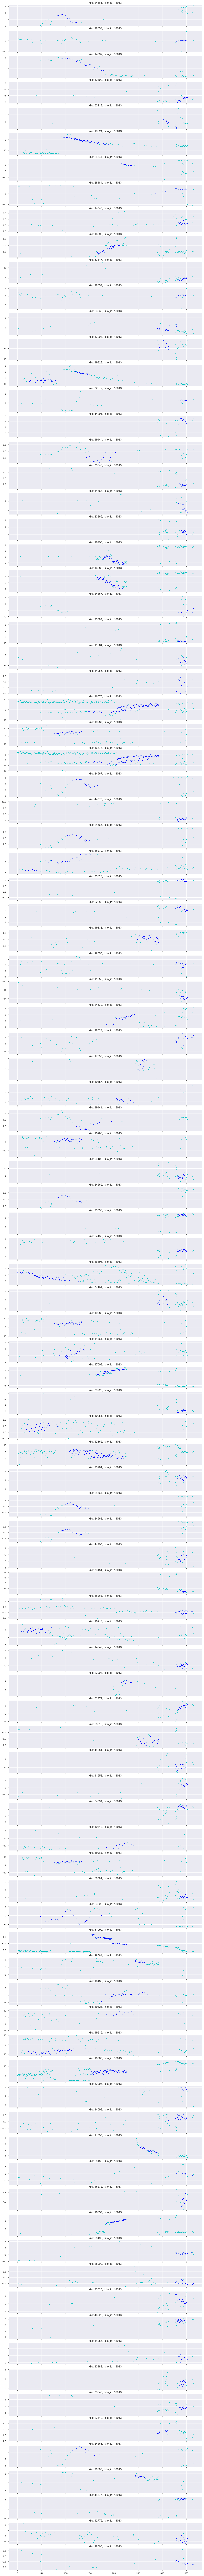

In [106]:
random.seed(10)

# fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)
fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True)

for i, (no, kilo) in enumerate(high):
    track = tracks[no]
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

#     kilo_id = kilo - 10000
#     hoge = [kilo_id + i*len(kilos) for i in range(91)]
#     piyo = submision.loc[hoge, 0]
#     axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

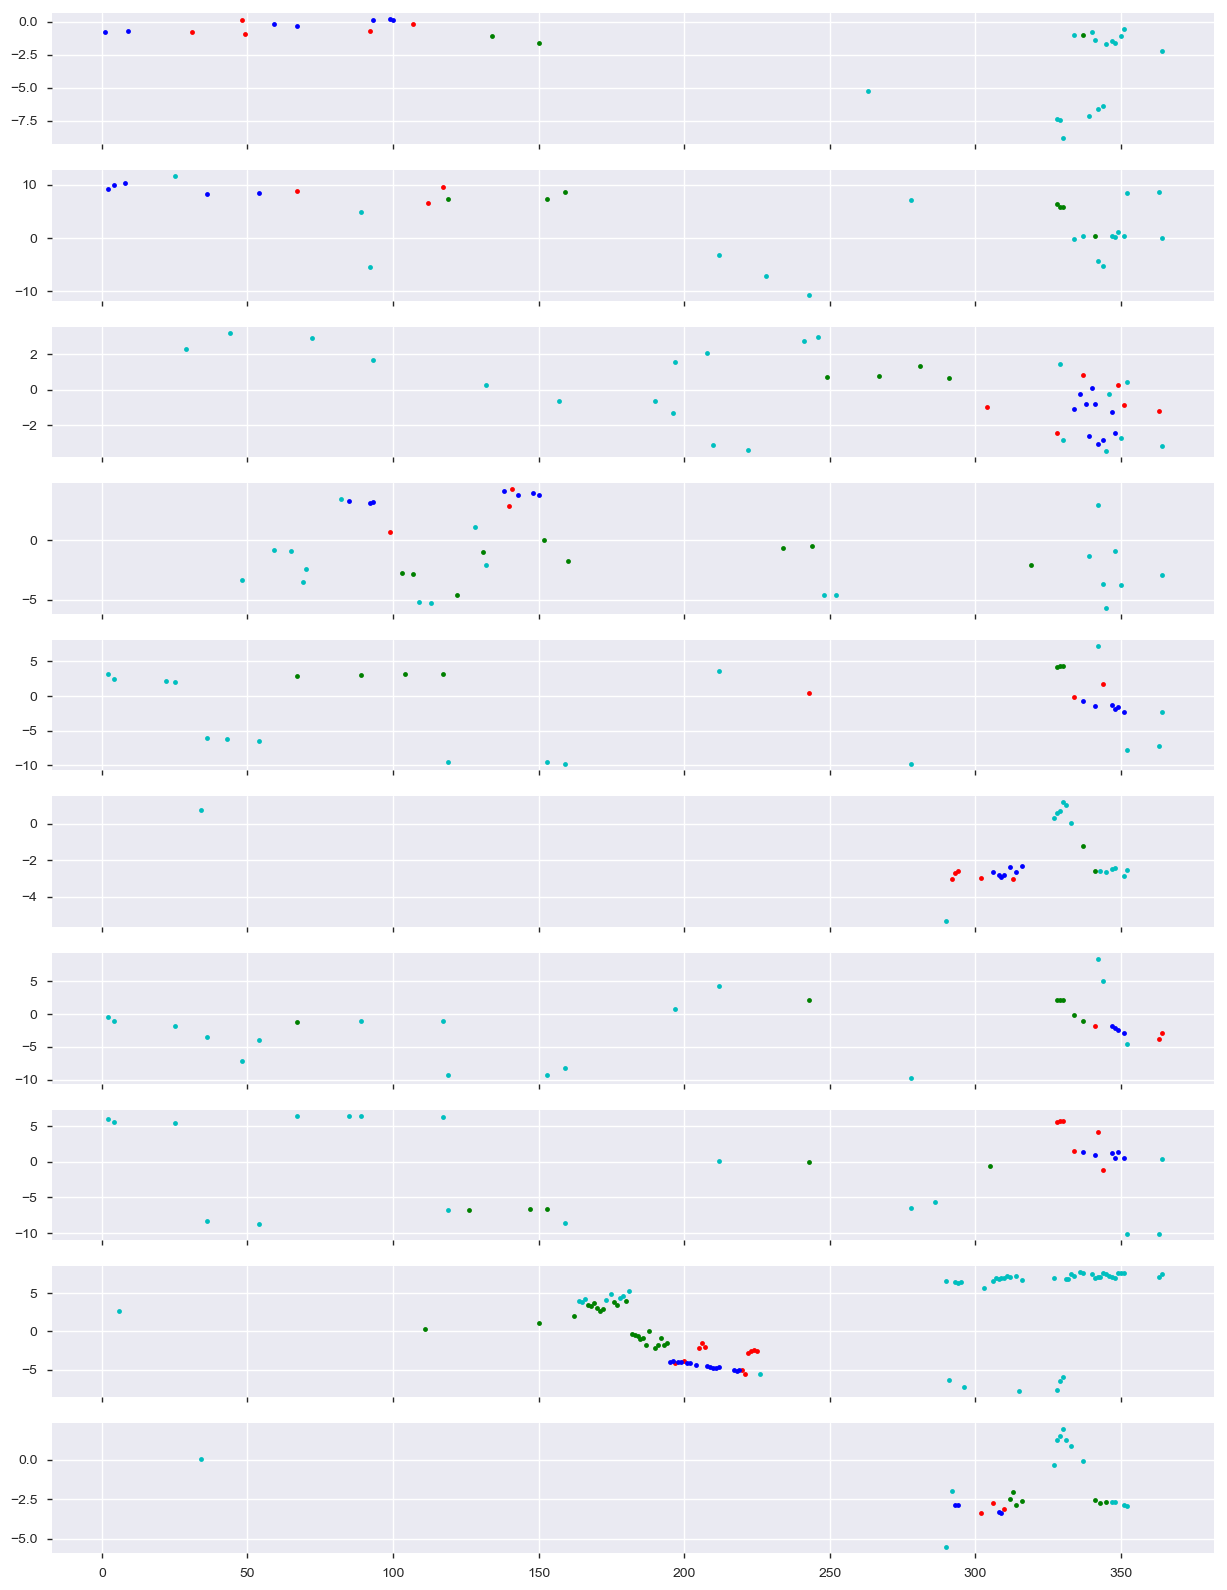

In [126]:
fig, axes = plt.subplots(10, 1, figsize=(15, 20), sharex=True)

for i, (no, kilo) in enumerate(high):
    track = tracks[no]
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [44]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(
            abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                df['高低左'].rolling(window=10, min_periods=1, center=False).median()))
    return df

In [125]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
#     normal_id = df[np.where(score_pred <= np.median(score_pred)*1.05, False, True)].index.values
    normal_id = df[np.where(score_pred <= np.median(score_pred)*0.9999, False, True)].index.values
    return normal_id

In [51]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, False, False, True)
    df = scaling(df, 100, 0, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.99999 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [53]:
def mcd_outliers(raw):
    df = raw.copy()
    mcd.fit(df)
    score_pred = mcd.mahalanobis(df)
    normal_id = df[np.where(score_pred >= np.median(score_pred)*1.25, False, True)].index.values
    return normal_id

In [111]:
def flag_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(mcd_outliers(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])

    out1 = set(local_global[0][1]) - set(local_global[1][1])
    out2 = set(local_global[1][1]) - set(local_global[2][1])
    out3 = set(local_global[2][1]) - set(local_global[3][1])
    normal = local_global[3][1]
    return out1, out2, out3, normal

In [65]:
p = []
intercept_day = 15
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    for i in range(91):
        day = summary['切片'].values + summary['傾き'].values*(i+intercept_day)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [66]:
submision.max()

0    45.83
dtype: float64

In [67]:
submision.min()

0   -28.17
dtype: float64

submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [34]:
len(submision[submision[0] >= 16])
len(submision[submision[0] <= -16])

477

826

In [35]:
submision

0
0          0.52
1          2.83
2          5.06
3          5.87
4          5.00
5          1.71
6         -3.07
7         -7.23
8         -8.86
9         -7.44
10        -3.38
11         1.06
12         4.56
13         5.43
14         3.74
15         1.04
16        -2.70
17        -4.83
18        -4.99
19        -3.67
20        -1.90
21        -0.41
22         0.00
23         0.18
24         0.88
25         2.31
26         3.84
27         4.07
28         1.99
29        -1.86
...         ...
10993862  -0.19
10993863  -0.63
10993864  -1.51
10993865  -2.13
10993866  -1.33
10993867   0.84
10993868   3.29
10993869   4.37
10993870   4.93
10993871   4.25
10993872   2.19
10993873  -1.19
10993874  -4.71
10993875  -8.13
10993876  -7.28
10993877  -5.93
10993878  -2.87
10993879   1.03
10993880   4.79
10993881   8.01
10993882   8.58
10993883   6.59
10993884   3.36
10993885  -1.53
10993886  -7.16
10993887 -11.43
10993888  -9.78
10993889  -5.35
10993890   0.15
10993891   3.86

[10993892 rows x 1 columns]

Text(0.5, 1.0, 'kilo: 28723,  kilo_id: 18723')

Text(0.5, 1.0, 'kilo: 11067,  kilo_id: 1067')

Text(0.5, 1.0, 'kilo: 24053,  kilo_id: 14053')

Text(0.5, 1.0, 'kilo: 25812,  kilo_id: 15812')

Text(0.5, 1.0, 'kilo: 28942,  kilo_id: 18942')

Text(0.5, 1.0, 'kilo: 10486,  kilo_id: 486')

Text(0.5, 1.0, 'kilo: 16753,  kilo_id: 6753')

Text(0.5, 1.0, 'kilo: 25157,  kilo_id: 15157')

Text(0.5, 1.0, 'kilo: 36650,  kilo_id: 26650')

Text(0.5, 1.0, 'kilo: 26098,  kilo_id: 16098')

Text(0.5, 1.0, 'kilo: 36987,  kilo_id: 26987')

Text(0.5, 1.0, 'kilo: 19093,  kilo_id: 9093')

Text(0.5, 1.0, 'kilo: 31412,  kilo_id: 21412')

Text(0.5, 1.0, 'kilo: 36562,  kilo_id: 26562')

Text(0.5, 1.0, 'kilo: 15250,  kilo_id: 5250')

Text(0.5, 1.0, 'kilo: 11127,  kilo_id: 1127')

Text(0.5, 1.0, 'kilo: 27061,  kilo_id: 17061')

Text(0.5, 1.0, 'kilo: 26059,  kilo_id: 16059')

Text(0.5, 1.0, 'kilo: 20740,  kilo_id: 10740')

Text(0.5, 1.0, 'kilo: 12493,  kilo_id: 2493')

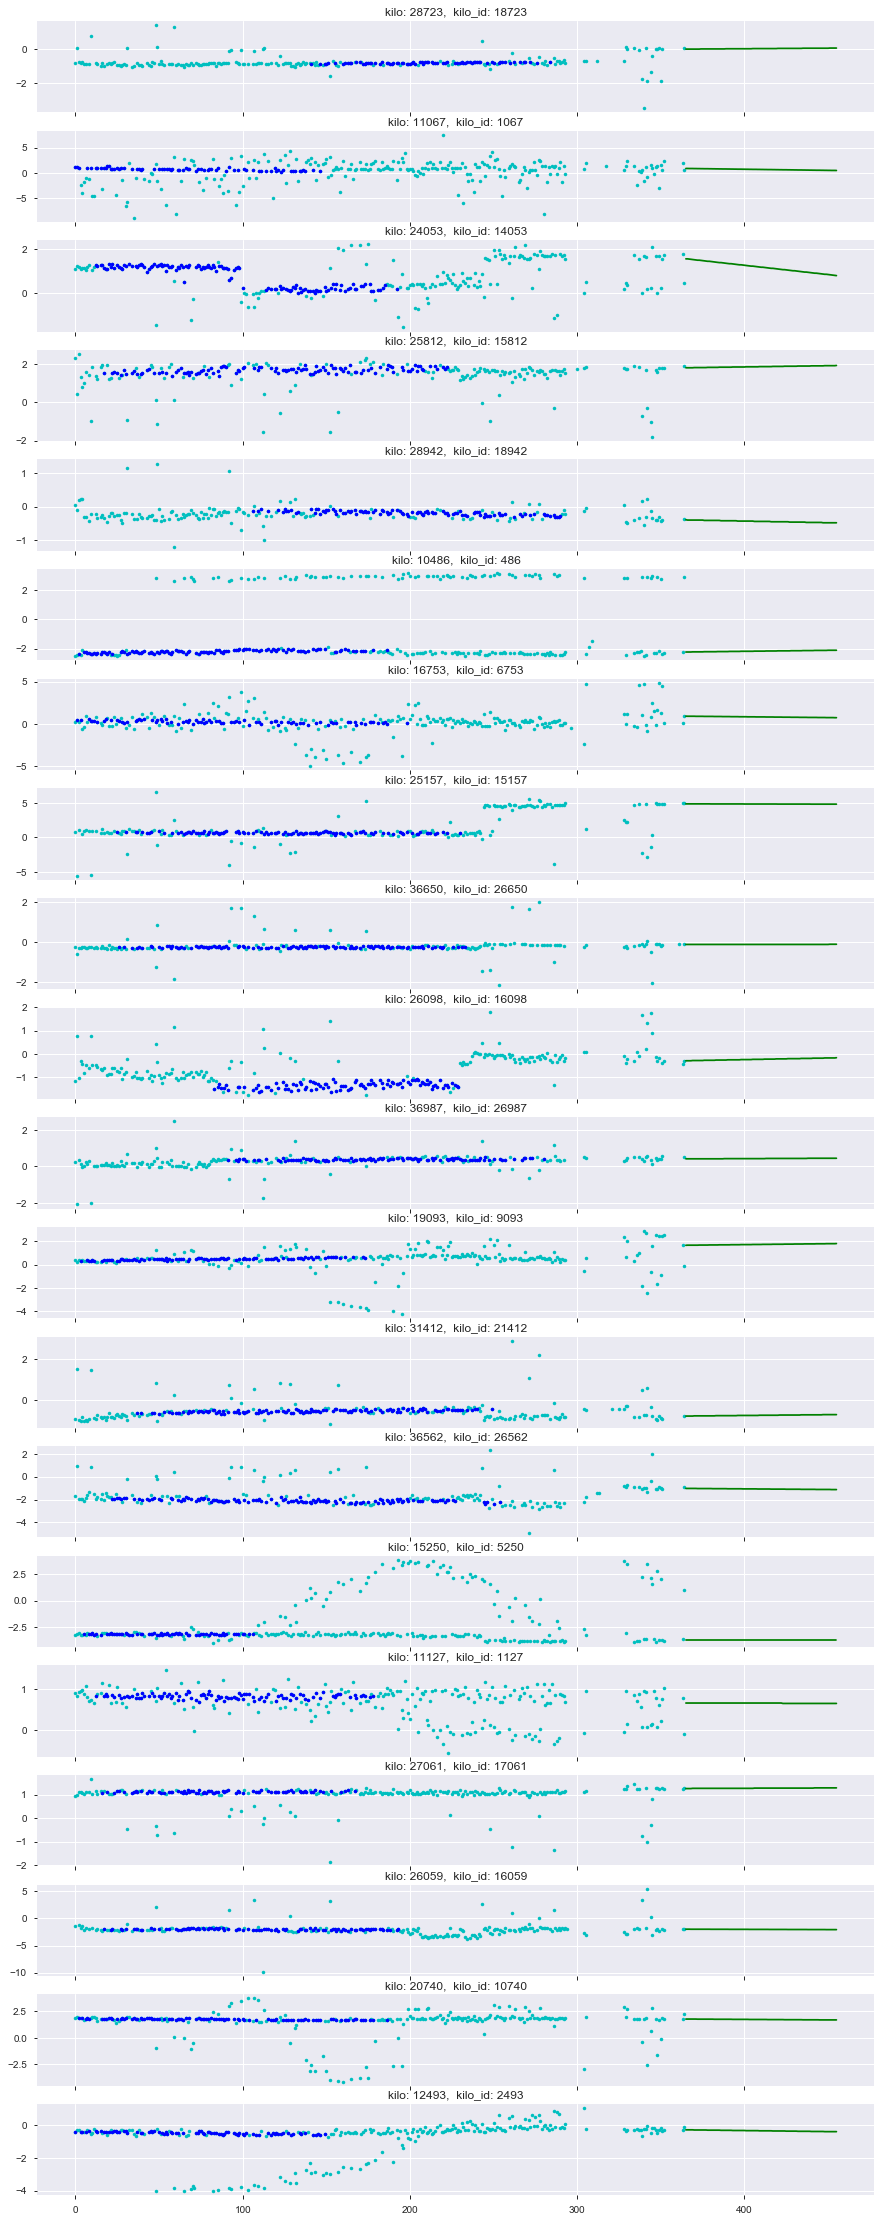

In [68]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

Text(0.5, 1.0, 'kilo: 11326,  kilo_id: 1326')

Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

Text(0.5, 1.0, 'kilo: 14579,  kilo_id: 4579')

Text(0.5, 1.0, 'kilo: 13107,  kilo_id: 3107')

Text(0.5, 1.0, 'kilo: 30262,  kilo_id: 20262')

Text(0.5, 1.0, 'kilo: 18208,  kilo_id: 8208')

Text(0.5, 1.0, 'kilo: 27451,  kilo_id: 17451')

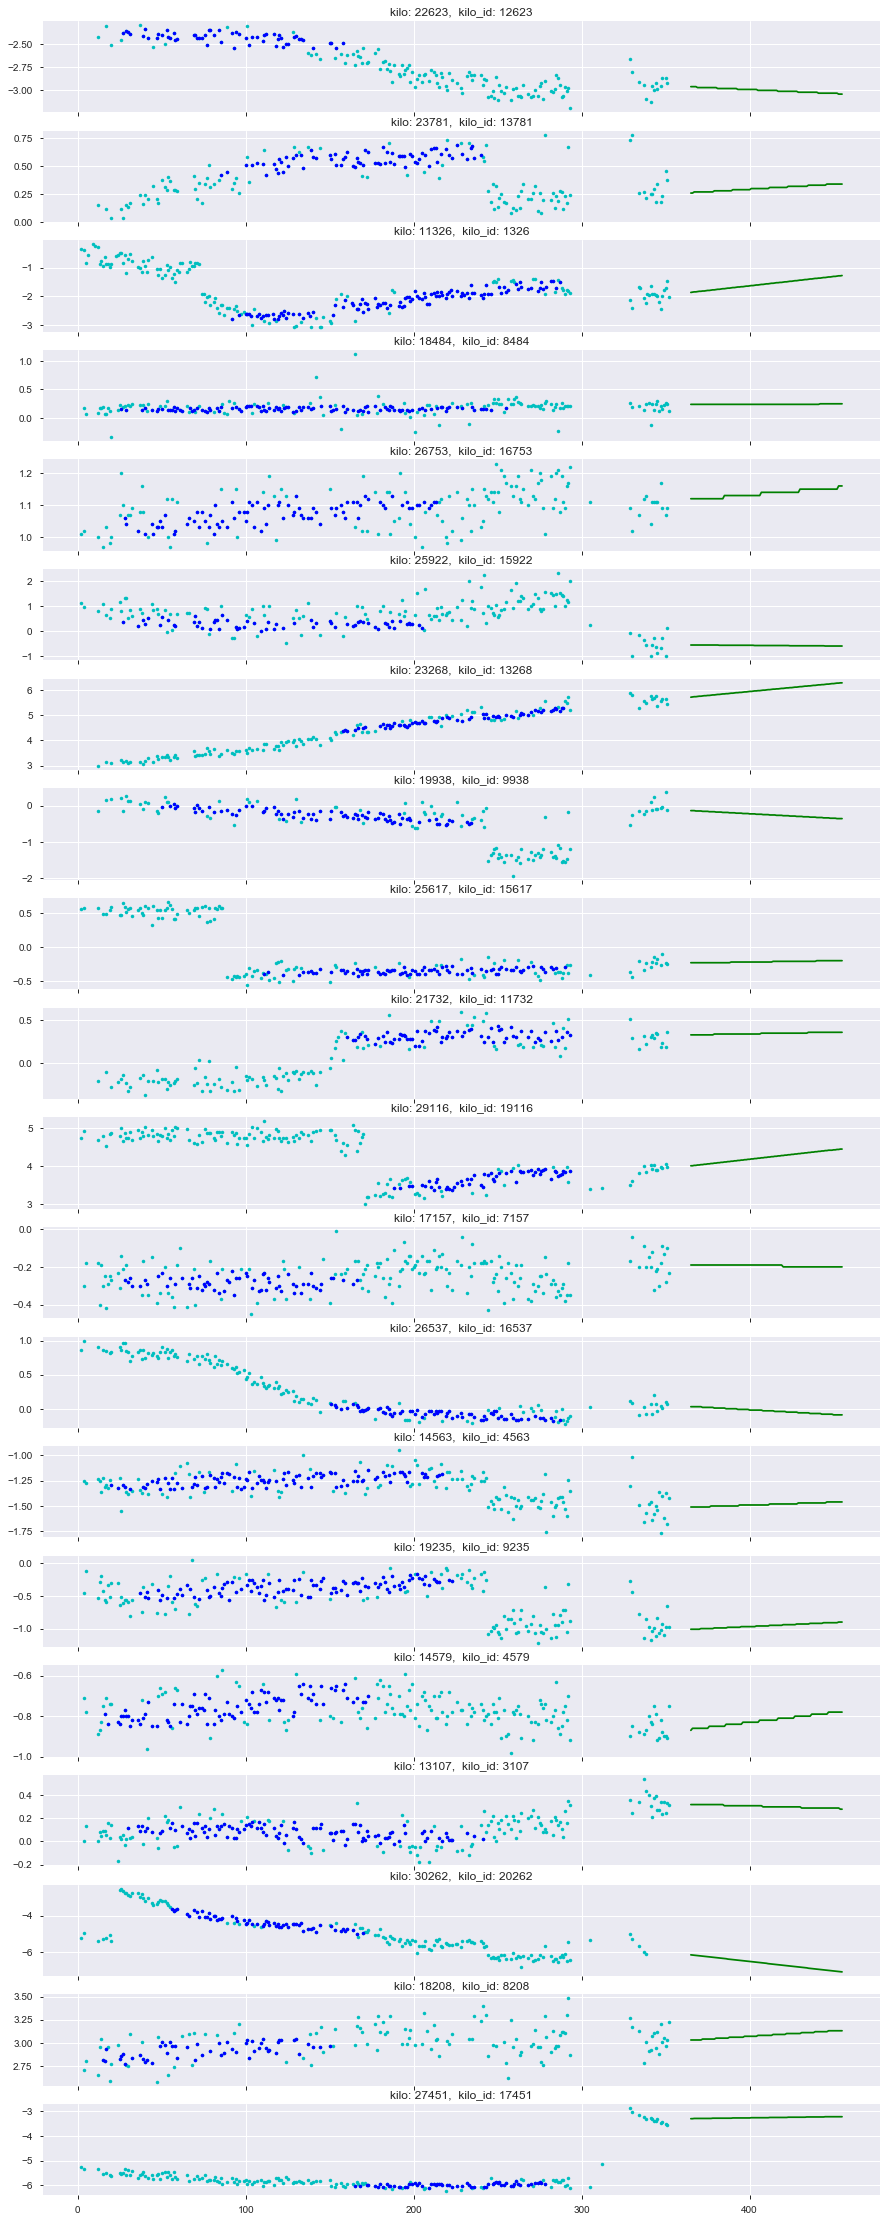

In [69]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 65340,  kilo_id: 55340')

Text(0.5, 1.0, 'kilo: 35247,  kilo_id: 25247')

Text(0.5, 1.0, 'kilo: 59673,  kilo_id: 49673')

Text(0.5, 1.0, 'kilo: 37562,  kilo_id: 27562')

Text(0.5, 1.0, 'kilo: 12653,  kilo_id: 2653')

Text(0.5, 1.0, 'kilo: 26968,  kilo_id: 16968')

Text(0.5, 1.0, 'kilo: 43506,  kilo_id: 33506')

Text(0.5, 1.0, 'kilo: 41845,  kilo_id: 31845')

Text(0.5, 1.0, 'kilo: 36537,  kilo_id: 26537')

Text(0.5, 1.0, 'kilo: 61367,  kilo_id: 51367')

Text(0.5, 1.0, 'kilo: 64385,  kilo_id: 54385')

Text(0.5, 1.0, 'kilo: 29877,  kilo_id: 19877')

Text(0.5, 1.0, 'kilo: 41234,  kilo_id: 31234')

Text(0.5, 1.0, 'kilo: 33465,  kilo_id: 23465')

Text(0.5, 1.0, 'kilo: 48232,  kilo_id: 38232')

Text(0.5, 1.0, 'kilo: 24315,  kilo_id: 14315')

Text(0.5, 1.0, 'kilo: 43075,  kilo_id: 33075')

Text(0.5, 1.0, 'kilo: 19127,  kilo_id: 9127')

Text(0.5, 1.0, 'kilo: 28470,  kilo_id: 18470')

Text(0.5, 1.0, 'kilo: 19158,  kilo_id: 9158')

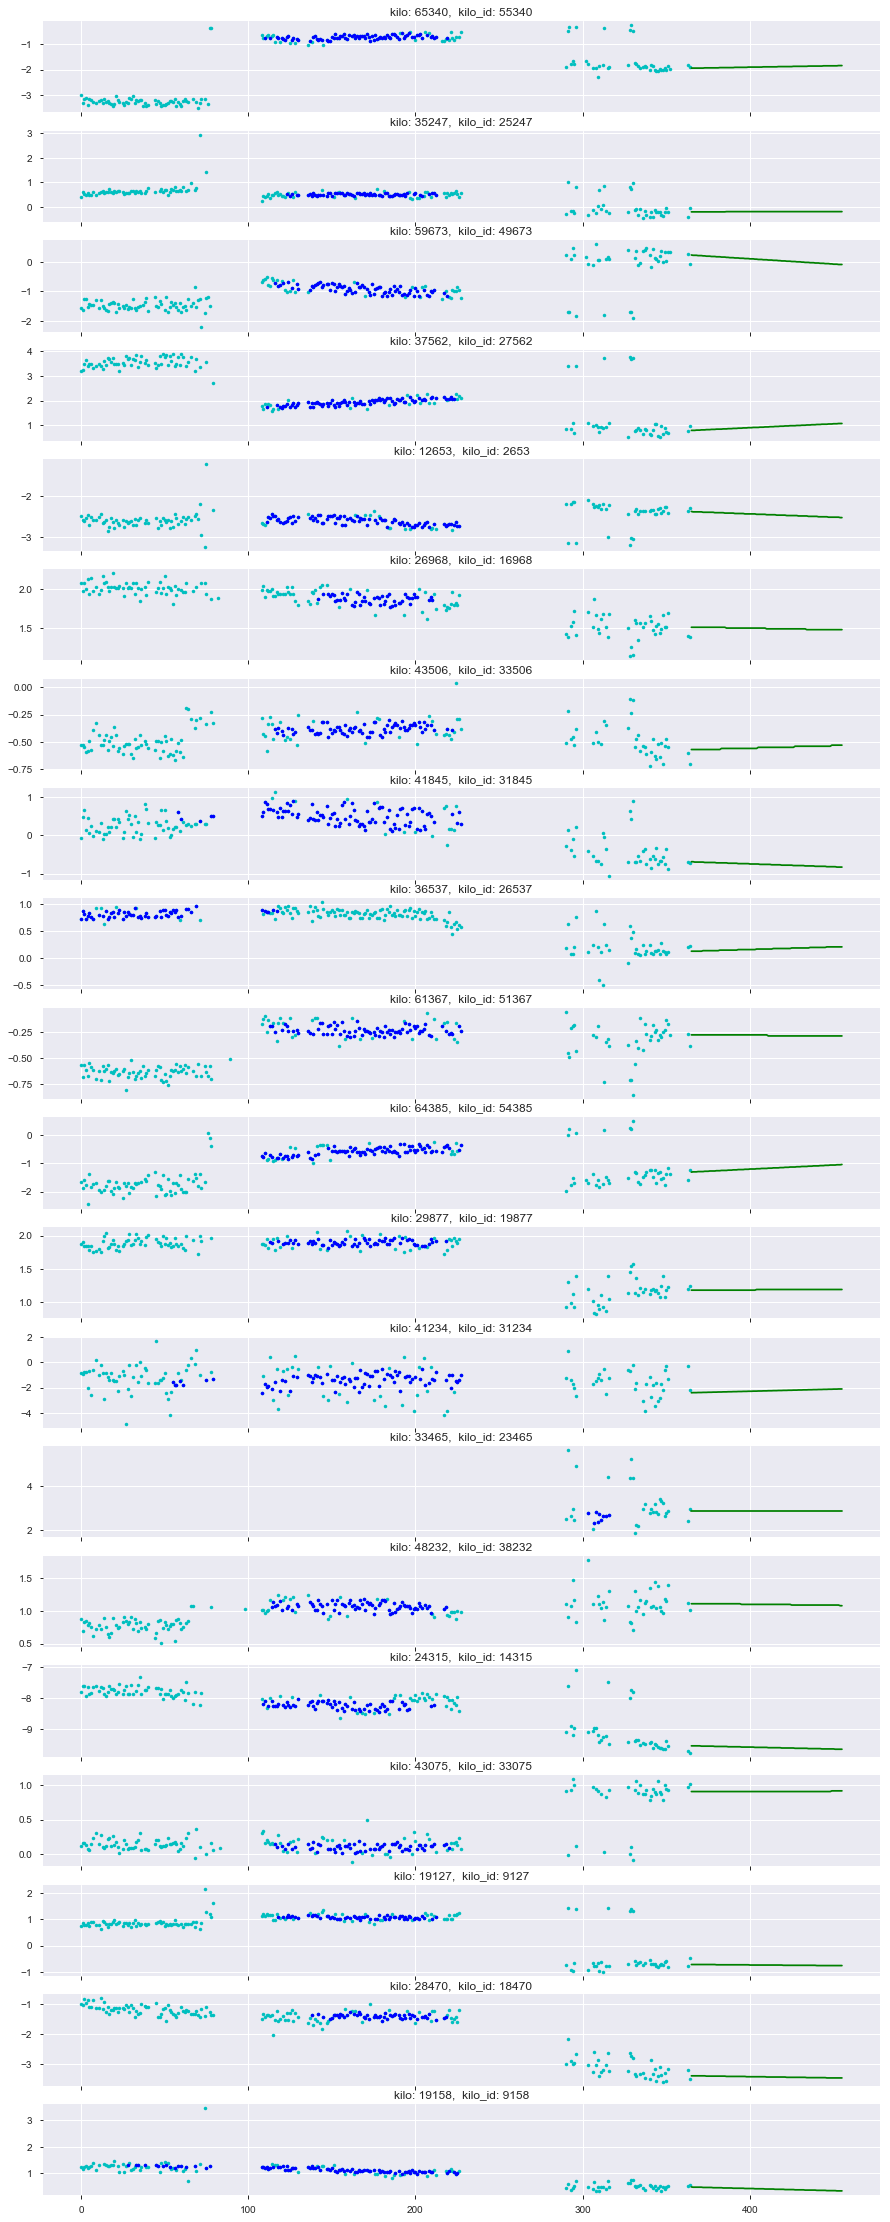

In [70]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 23835,  kilo_id: 13835')

Text(0.5, 1.0, 'kilo: 16311,  kilo_id: 6311')

Text(0.5, 1.0, 'kilo: 22418,  kilo_id: 12418')

Text(0.5, 1.0, 'kilo: 24585,  kilo_id: 14585')

Text(0.5, 1.0, 'kilo: 16890,  kilo_id: 6890')

Text(0.5, 1.0, 'kilo: 10663,  kilo_id: 663')

Text(0.5, 1.0, 'kilo: 14242,  kilo_id: 4242')

Text(0.5, 1.0, 'kilo: 18376,  kilo_id: 8376')

Text(0.5, 1.0, 'kilo: 17961,  kilo_id: 7961')

Text(0.5, 1.0, 'kilo: 16634,  kilo_id: 6634')

Text(0.5, 1.0, 'kilo: 25044,  kilo_id: 15044')

Text(0.5, 1.0, 'kilo: 22841,  kilo_id: 12841')

Text(0.5, 1.0, 'kilo: 23596,  kilo_id: 13596')

Text(0.5, 1.0, 'kilo: 14969,  kilo_id: 4969')

Text(0.5, 1.0, 'kilo: 17808,  kilo_id: 7808')

Text(0.5, 1.0, 'kilo: 15866,  kilo_id: 5866')

Text(0.5, 1.0, 'kilo: 19558,  kilo_id: 9558')

Text(0.5, 1.0, 'kilo: 24608,  kilo_id: 14608')

Text(0.5, 1.0, 'kilo: 24878,  kilo_id: 14878')

Text(0.5, 1.0, 'kilo: 13578,  kilo_id: 3578')

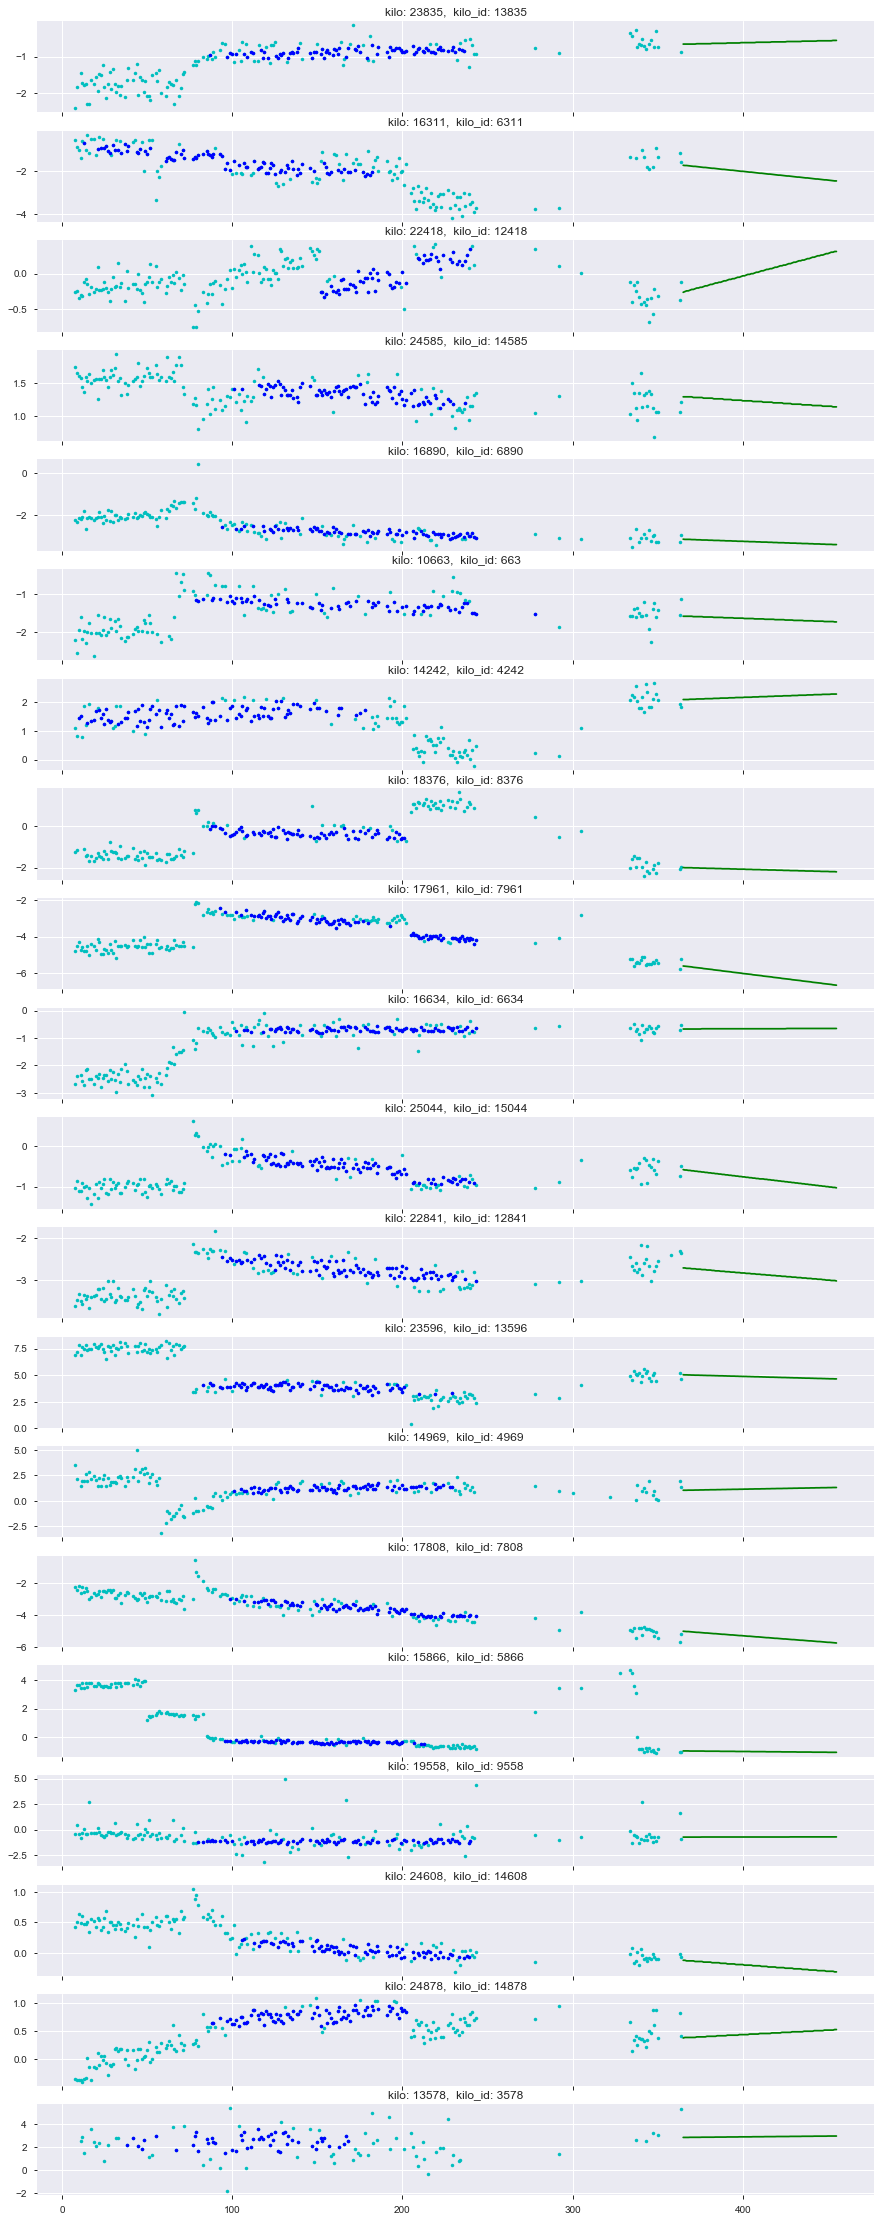

In [71]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [56]:
submision.to_csv("submit15_lgbm.csv", header=None)